# Setup

You can open the Colab notebook version of this Jupyter notebook here for the latest updates: https://colab.research.google.com/drive/1lcEF_rHSl1oS4pZg2NKSLZBTc0O7RpAK?usp=sharing.

In [ ]:
import os
import time
import math
# use this display function to display DataFrames nicely
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# # change the font_scale all at once
sns.set(font_scale=1.5)

# use the ggplot theme for our figures
plt.style.use('ggplot')
# set default figure size
plt.rcParams['figure.figsize'] = (16, 10)

In [ ]:
# check whether your PyTorch has access to GPU
# if you don't, make sure to follow the steps mentioned
#  in the README file.
torch.cuda.is_available()

True

In [ ]:
torch.__version__

'1.9.0+cu102'

In [ ]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
# set up the device to use for our torch tensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

You may choose to download the dataset from Kaggle and upload the entire dataset into Google Drive directly for faster upload time than uploading to here directly. Or just directly download the dataset into the Google Colab environment here by using Kaggle API. 

1. Go to homepage www.kaggle.com -> Your Account -> Create New API token and a `kaggle.json` file will be downloaded.
2. Upload the `kaggle.json` file to Google Colab at the left panel.
3. Then, run the cell below to create a kaggle directory and copy the `kaggle.json` API key into the directory.

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c career-con-2019

X_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
y_train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
X_test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip --qq X_train.csv.zip

In [ ]:
X_train = pd.read_csv("X_train.csv")
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [ ]:
y_train = pd.read_csv("y_train.csv")
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


# Training Config

In [ ]:
BATCH_SIZE = 64
EPOCHS = 250
LEARNING_RATE = 1e-4

CHECKPOINT_PATH = "my_checkpoint.pth.tar"

SEQUENCE_LENGTH = 128
N_CLASSES = y_train['surface'].nunique()

In [ ]:
N_CLASSES

9

# Some Visualizations

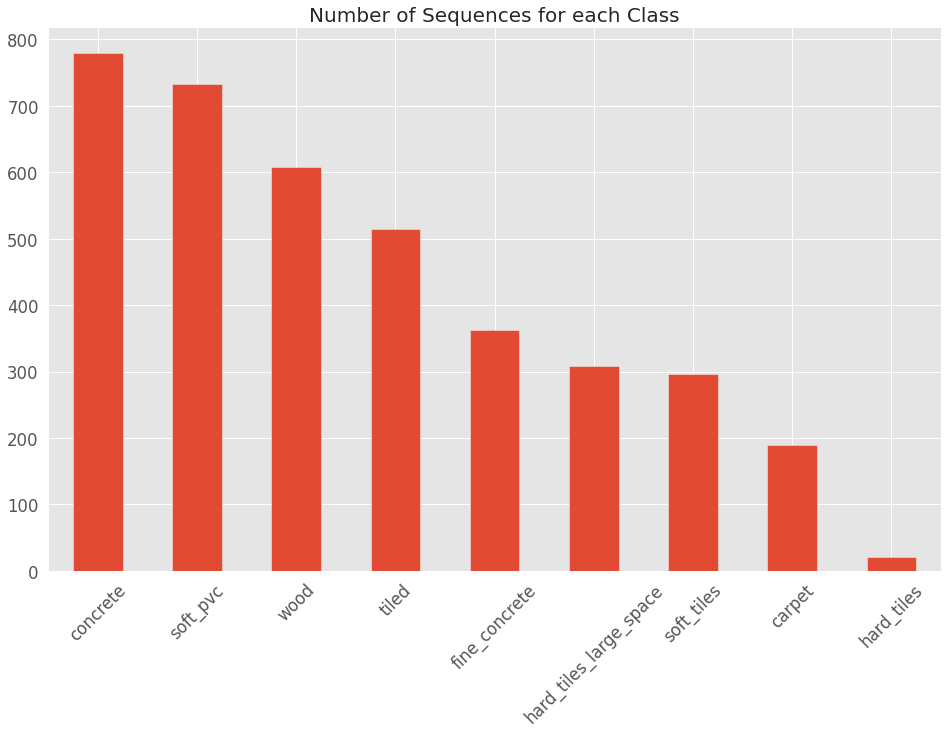

In [ ]:
y_train['surface'].value_counts().plot(kind='bar')
plt.title("Number of Sequences for each Class", size=20)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# get the feature columns
feature_cols = X_train.columns[3:].values
feature_cols

array(['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W',
       'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
       'linear_acceleration_X', 'linear_acceleration_Y',
       'linear_acceleration_Z'], dtype=object)

Surface = hard_tiles



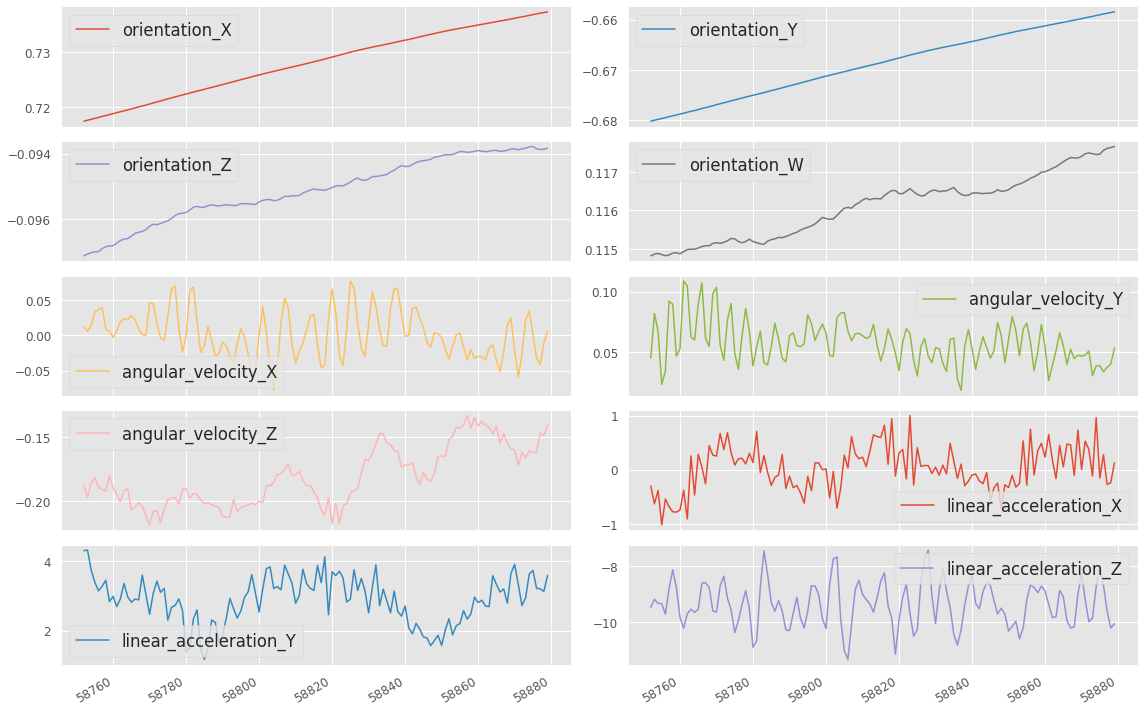

In [ ]:
# DRAW A PLOT OF TIME SERIES
random_idx = np.random.randint(X_train['series_id'].nunique())
row = X_train.loc[X_train['series_id'] == random_idx]
label = y_train.loc[y_train['series_id'] == random_idx, 'surface'].values[0]

print(f"Surface = {label}\n")
row[feature_cols].plot(
    subplots=True,
    layout=(5, 2),
    fontsize=12,
)
plt.tight_layout()
plt.show()

# Preprocess the data

In [ ]:
encoder = LabelEncoder()
y_train['encoded_label'] = encoder.fit_transform(y_train['surface'])
y_train.head(10)

,series_id,group_id,surface,encoded_label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6
5,5,1,tiled,7
6,6,34,soft_pvc,5
7,7,31,concrete,1
8,8,33,hard_tiles_large_space,4
9,9,11,tiled,7


In [ ]:
y_train.encoded_label.unique()

array([2, 1, 6, 7, 5, 4, 0, 3, 8])

In [ ]:
encoder.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [ ]:
# get the feature columns
feature_cols = X_train.columns[3:].values
feature_cols

array(['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W',
       'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
       'linear_acceleration_X', 'linear_acceleration_Y',
       'linear_acceleration_Z'], dtype=object)

In [ ]:
# there are 128 timesteps for each sequence
(X_train.groupby("series_id")['row_id'].count() == 128).all()

True

In [ ]:
# create a list of tuples of sequences and encoded labels
sequence_list = []
for series_id, group in X_train.groupby("series_id"):
    sequence = group[feature_cols].values
    label = y_train.loc[y_train['series_id'] == series_id,
                        'encoded_label'].values[0]
    # append the sequence and label as tuple into the list
    sequence_list.append((sequence, label))

In [ ]:
# showing an example of sequence with its label
sequence_idx = 0
sequence = sequence_list[sequence_idx][0]
label = sequence_list[sequence_idx][1]
print(f"label = {label}")
print(encoder.inverse_transform([label]))
print(sequence)

label = 2
['fine_concrete']
[[ -0.75853  -0.63435  -0.10488 ...  -0.74857   2.103    -9.7532 ]
 [ -0.75853  -0.63434  -0.1049  ...   0.33995   1.5064   -9.4128 ]
 [ -0.75853  -0.63435  -0.10492 ...  -0.26429   1.5922   -8.7267 ]
 ...
 [ -0.75949  -0.63309  -0.10467 ...  -0.98193   0.97328  -9.9795 ]
 [ -0.7595   -0.63307  -0.10464 ...  -0.72591   0.34931 -11.977  ]
 [ -0.75953  -0.63306  -0.10461 ...  -0.53426   0.80346 -10.697  ]]


In [ ]:
train_sequences, val_sequences = train_test_split(
    sequence_list,
    test_size=0.2,
    random_state=RANDOM_SEED,
)
print(len(train_sequences))
print(len(val_sequences))

3048
762


# Create PyTorch Dataset and DataLoaders

In [ ]:
# create PyTorch dataset by inheriting the Dataset class
class SequenceDataset(Dataset):
    def __init__(self, sequence_list):
        """The `sequence_list` parameter contains tuples of (sequence, label)."""
        self.sequence_list = sequence_list
        
    def __len__(self):
        return len(self.sequence_list)
    
    def __getitem__(self, idx):
        sequence = sequence_list[idx][0]
        label = sequence_list[idx][1]
        
        sequence = torch.tensor(sequence).float()
        label = torch.tensor(label)
        return sequence, label

In [ ]:
train_dataset = SequenceDataset(train_sequences)
val_dataset = SequenceDataset(val_sequences)

In [ ]:
for x, y in train_dataset:
    print(y)
    print(x)
    print(x.shape)
    break

tensor(2)
tensor([[ -0.7585,  -0.6344,  -0.1049,  ...,  -0.7486,   2.1030,  -9.7532],
        [ -0.7585,  -0.6343,  -0.1049,  ...,   0.3399,   1.5064,  -9.4128],
        [ -0.7585,  -0.6344,  -0.1049,  ...,  -0.2643,   1.5922,  -8.7267],
        ...,
        [ -0.7595,  -0.6331,  -0.1047,  ...,  -0.9819,   0.9733,  -9.9795],
        [ -0.7595,  -0.6331,  -0.1046,  ...,  -0.7259,   0.3493, -11.9770],
        [ -0.7595,  -0.6331,  -0.1046,  ...,  -0.5343,   0.8035, -10.6970]])
torch.Size([128, 10])


In [ ]:
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
# we use the validation dataset as our test set in this case since we don't have
#  access to the test set in Kaggle competition
test_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 128, 10])
torch.Size([64])


# Build Model

In [ ]:
class SequenceModel(nn.Module):
    def __init__(self, n_features, n_classes=N_CLASSES, n_hidden=256, n_layers=3, verbose=0):
        super().__init__()

        self.verbose = verbose

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.75
        )

        self.fc = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        last_hidden, (hidden_states, _) = self.lstm(x)
        last_output = hidden_states[-1]
        x = self.fc(last_output)
        
        if self.verbose:
            print(f"last_hidden.shape = {last_hidden.shape}")
            print(f"hidden_states.shape = {hidden_states.shape}")
            print(f"last_output.shape = {last_output.shape}")
            print(f"output shape = {x.shape}")
        return x

In [ ]:
model = SequenceModel(
    n_features=len(feature_cols),
    n_classes=N_CLASSES,
    n_hidden=256,
    n_layers=3
)
model.to(device)

SequenceModel(
  (lstm): LSTM(10, 256, num_layers=3, batch_first=True, dropout=0.75)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [ ]:
model(x.to(device)).shape

torch.Size([64, 9])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

# Training

In [ ]:
## optionally use tqdm with colored progress bar
# from tqdm.notebook import tqdm as tqdm_notebook

steps_per_epoch = math.ceil(len(train_dataset) / train_dl.batch_size)
prog_bar = tqdm(
    enumerate(train_dl),
    total=steps_per_epoch,
    leave=True
)

for x in prog_bar:
    time.sleep(0.1)

48it [00:05,  9.24it/s]


In [ ]:
def fit(model, train_dl, train_dataset, optimizer, criterion):
    # set to training mode
    model.train()
    
    counter = 0
    total = 0
    train_running_loss = 0.0
    train_running_correct = 0

    steps_per_epoch = math.ceil(len(train_dataset) / train_dl.batch_size)
    prog_bar = tqdm(
        enumerate(train_dl),
        total=steps_per_epoch,
        leave=False
    )

    for batch_idx, (sequences, labels) in prog_bar:
        train_running_loss = 0.0
        train_running_correct = 0
        counter = 0
        total = 0

        sequences = sequences.to(device)
        labels = labels.to(device)

        y_pred = model(sequences)
        # y_pred = torch.argmax(y_proba, axis=-1)

        # print(y_pred.shape)
        # print(labels.shape)

        # calculate the loss
        loss = criterion(y_pred, labels)
        
        # must reset the gradients to zero before update gradients for
        # current batch
        optimizer.zero_grad()

        # backward propagation to update gradients
        loss.backward()

        # gradient descent using optimizer
        optimizer.step()

        counter += 1
        total += len(labels)
        train_running_correct += (torch.argmax(y_pred, -1) == labels).sum().item()
        train_running_loss += loss.item()

    train_accuracy = train_running_correct / total
    train_loss = train_running_loss / counter
    return train_accuracy, train_loss

In [ ]:
def validate(model, val_dl, val_dataset, criterion):
    # set to evaluation mode
    model.eval()

    counter = 0
    total = 0
    val_running_loss = 0.0
    val_running_correct = 0

    steps_per_epoch = math.ceil(len(val_dataset) / val_dl.batch_size)
    prog_bar = tqdm(
        enumerate(val_dl),
        total=steps_per_epoch,
        leave=False
    )

    # do not update gradients here
    with torch.no_grad():
        for batch_idx, (sequences, labels) in prog_bar:
            sequences = sequences.to(device)
            labels = labels.to(device)

            y_pred = model(sequences)
            # y_pred = torch.argmax(y_proba, axis=-1)

            loss = criterion(y_pred, labels)

            counter += 1
            total += len(labels)
            val_running_correct += (torch.argmax(y_pred, -1) == labels).sum().item()
            val_running_loss += loss.item()

        val_accuracy = val_running_correct / total
        val_loss = val_running_loss / counter
    
    return val_accuracy, val_loss

In [ ]:
def save_ckpt(state, filepath="my_checkpoint.pth.tar"):
    print(f"[INFO] Saving checkpoint to {filepath}")
    torch.save(state, filepath)

In [ ]:
from collections import defaultdict

# to store our training accuracy and losses
history = defaultdict(list)
best_val_loss = np.inf

for epoch in range(EPOCHS):
    print(f"Epoch ({epoch}/{EPOCHS}):", end="")
    start_t = time.perf_counter()

    train_accuracy, train_loss = fit(
        model,
        train_dl,
        train_dataset,
        optimizer,
        criterion
    )

    val_accuracy, val_loss = validate(
        model,
        val_dl,
        val_dataset,
        criterion
    )

    end_t = time.perf_counter()
    print(f" {end_t - start_t:.2f} s")

    ## optionally can save checkpoint automatically
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_ckpt(model.state_dict(), CHECKPOINT_PATH)
    
    scheduler.step(val_loss)

    history['train_accuracy'].append(train_accuracy)
    history['train_loss'].append(train_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_loss'].append(val_loss)

    print(f"accuracy = {train_accuracy}  loss = {train_loss}  "
    f"val_accuracy = {val_accuracy}  val_loss = {val_loss}\n")

Epoch (0/250):

 6.31 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.3  loss = 1.9219573736190796  val_accuracy = 0.22440944881889763  val_loss = 2.1030176182587943

Epoch (1/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.15  loss = 2.085019588470459  val_accuracy = 0.22572178477690288  val_loss = 2.072087128957113

Epoch (2/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.275  loss = 2.060514211654663  val_accuracy = 0.3333333333333333  val_loss = 2.0381898085276284

Epoch (3/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.2  loss = 1.9515098333358765  val_accuracy = 0.36089238845144356  val_loss = 1.9135826230049133

Epoch (4/250):

 6.17 s
accuracy = 0.25  loss = 1.9761991500854492  val_accuracy = 0.3569553805774278  val_loss = 2.0423551897207894

Epoch (5/250):

 6.18 s
accuracy = 0.225  loss = 1.9890167713165283  val_accuracy = 0.35170603674540685  val_loss = 2.016828715801239

Epoch (6/250):

 6.17 s
accuracy = 0.25  loss = 2.0096819400787354  val_accuracy = 0.32545931758530183  val_loss = 1.9796443978945415

Epoch (7/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.375  loss = 1.851356863975525  val_accuracy = 0.3530183727034121  val_loss = 1.8774768114089966

Epoch (8/250):

 6.16 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.275  loss = 1.8261337280273438  val_accuracy = 0.3451443569553806  val_loss = 1.8276821374893188

Epoch (9/250):

 6.16 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.35  loss = 1.8967702388763428  val_accuracy = 0.37401574803149606  val_loss = 1.7567924360434215

Epoch (10/250):

 6.16 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.325  loss = 1.8333631753921509  val_accuracy = 0.3766404199475066  val_loss = 1.7051315406958263

Epoch (11/250):

 6.18 s
accuracy = 0.375  loss = 1.6770312786102295  val_accuracy = 0.3766404199475066  val_loss = 1.7367398242155712

Epoch (12/250):

 6.30 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.325  loss = 1.8213293552398682  val_accuracy = 0.3884514435695538  val_loss = 1.6762555241584778

Epoch (13/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.375  loss = 1.580857276916504  val_accuracy = 0.40551181102362205  val_loss = 1.6203183432420094

Epoch (14/250):

 6.24 s
accuracy = 0.375  loss = 1.683645248413086  val_accuracy = 0.3989501312335958  val_loss = 1.7806963125864665

Epoch (15/250):

 6.17 s
accuracy = 0.325  loss = 1.58206307888031  val_accuracy = 0.36089238845144356  val_loss = 1.6374336779117584

Epoch (16/250):

 6.19 s
accuracy = 0.325  loss = 1.6903187036514282  val_accuracy = 0.38451443569553806  val_loss = 1.6497453053792317

Epoch (17/250):

 6.17 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.325  loss = 1.577498197555542  val_accuracy = 0.3700787401574803  val_loss = 1.6061000923315685

Epoch (18/250):

 6.18 s
accuracy = 0.375  loss = 1.7270119190216064  val_accuracy = 0.4409448818897638  val_loss = 1.6617911954720814

Epoch (19/250):

 6.17 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.325  loss = 1.7339775562286377  val_accuracy = 0.4448818897637795  val_loss = 1.5790755152702332

Epoch (20/250):

 6.19 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.425  loss = 1.6055415868759155  val_accuracy = 0.46194225721784776  val_loss = 1.519647051890691

Epoch (21/250):

 6.18 s
accuracy = 0.525  loss = 1.5808532238006592  val_accuracy = 0.41732283464566927  val_loss = 1.5623035530249278

Epoch (22/250):

 6.16 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.425  loss = 1.5959866046905518  val_accuracy = 0.5223097112860893  val_loss = 1.4071409304936726

Epoch (23/250):

 6.19 s
accuracy = 0.4  loss = 1.420098066329956  val_accuracy = 0.5341207349081365  val_loss = 1.4163017372290294

Epoch (24/250):

 6.19 s
accuracy = 0.425  loss = 1.5886461734771729  val_accuracy = 0.5131233595800525  val_loss = 1.4998389979203541

Epoch (25/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.5  loss = 1.3145849704742432  val_accuracy = 0.46981627296587924  val_loss = 1.4061061441898346

Epoch (26/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.425  loss = 1.3433682918548584  val_accuracy = 0.5065616797900262  val_loss = 1.341484804948171

Epoch (27/250):

 6.23 s
accuracy = 0.525  loss = 1.2043371200561523  val_accuracy = 0.41601049868766404  val_loss = 1.4311450223128002

Epoch (28/250):

 6.18 s
accuracy = 0.35  loss = 1.4899697303771973  val_accuracy = 0.3779527559055118  val_loss = 1.6208759248256683

Epoch (29/250):

 6.19 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.375  loss = 1.4401599168777466  val_accuracy = 0.5196850393700787  val_loss = 1.3414071202278137

Epoch (30/250):

 6.23 s
accuracy = 0.35  loss = 1.5048096179962158  val_accuracy = 0.5498687664041995  val_loss = 1.3494716386000316

Epoch (31/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.475  loss = 1.4780312776565552  val_accuracy = 0.5787401574803149  val_loss = 1.247081955273946

Epoch (32/250):

 6.19 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.575  loss = 1.4218053817749023  val_accuracy = 0.5761154855643045  val_loss = 1.2082995772361755

Epoch (33/250):

 6.18 s
accuracy = 0.525  loss = 1.4198276996612549  val_accuracy = 0.5183727034120735  val_loss = 1.3171594142913818

Epoch (34/250):

 6.18 s
accuracy = 0.5  loss = 1.4156863689422607  val_accuracy = 0.5  val_loss = 1.432849109172821

Epoch (35/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.375  loss = 1.4924275875091553  val_accuracy = 0.573490813648294  val_loss = 1.1605190684398015

Epoch (36/250):

 6.16 s
accuracy = 0.575  loss = 1.292881727218628  val_accuracy = 0.41338582677165353  val_loss = 1.512596199909846

Epoch (37/250):

 6.21 s
accuracy = 0.55  loss = 1.3197208642959595  val_accuracy = 0.5748031496062992  val_loss = 1.2239116728305817

Epoch (38/250):

 6.21 s
accuracy = 0.55  loss = 1.317321538925171  val_accuracy = 0.610236220472441  val_loss = 1.2014499455690384

Epoch (39/250):

 6.17 s
accuracy = 0.55  loss = 1.1779998540878296  val_accuracy = 0.6023622047244095  val_loss = 1.2131884495417278

Epoch (40/250):

 6.20 s
accuracy = 0.475  loss = 1.263486623764038  val_accuracy = 0.6062992125984252  val_loss = 1.1682250499725342

Epoch (41/250):

 6.21 s
accuracy = 0.55  loss = 1.2398868799209595  val_accuracy = 0.5328083989501312  val_loss = 1.3083298901716869

Epoch (42/250):

 6.19 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.625  loss = 1.1151150465011597  val_accuracy = 0.610236220472441  val_loss = 1.1321761012077332

Epoch (43/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.575  loss = 1.4256895780563354  val_accuracy = 0.6141732283464567  val_loss = 1.1211833357810974

Epoch (44/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.6  loss = 1.1489431858062744  val_accuracy = 0.6089238845144357  val_loss = 1.1191773265600204

Epoch (45/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.55  loss = 1.1407808065414429  val_accuracy = 0.6220472440944882  val_loss = 1.1025516390800476

Epoch (46/250):

 6.19 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.55  loss = 1.222364902496338  val_accuracy = 0.6404199475065617  val_loss = 1.064544250567754

Epoch (47/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.625  loss = 1.1083518266677856  val_accuracy = 0.6614173228346457  val_loss = 1.0339492013057072

Epoch (48/250):

 6.15 s
accuracy = 0.475  loss = 1.3424556255340576  val_accuracy = 0.6220472440944882  val_loss = 1.0833049515883129

Epoch (49/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.575  loss = 0.9552260637283325  val_accuracy = 0.6601049868766404  val_loss = 0.9661645193894705

Epoch (50/250):

 6.20 s
accuracy = 0.75  loss = 0.9779297113418579  val_accuracy = 0.6548556430446194  val_loss = 1.0011866142352421

Epoch (51/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.6  loss = 1.1153274774551392  val_accuracy = 0.6692913385826772  val_loss = 0.9421239793300629

Epoch (52/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.675  loss = 0.9890475273132324  val_accuracy = 0.6916010498687664  val_loss = 0.9210591912269592

Epoch (53/250):

 6.18 s
accuracy = 0.7  loss = 0.8646427989006042  val_accuracy = 0.6653543307086615  val_loss = 0.940120279788971

Epoch (54/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.625  loss = 1.0569379329681396  val_accuracy = 0.7099737532808399  val_loss = 0.8360779931147894

Epoch (55/250):

 6.20 s
accuracy = 0.675  loss = 1.114290475845337  val_accuracy = 0.6417322834645669  val_loss = 0.955507829785347

Epoch (56/250):

 6.19 s
accuracy = 0.625  loss = 1.0613315105438232  val_accuracy = 0.6614173228346457  val_loss = 0.9296911060810089

Epoch (57/250):

 6.20 s
accuracy = 0.575  loss = 1.2620887756347656  val_accuracy = 0.6666666666666666  val_loss = 0.912939523657163

Epoch (58/250):

 6.19 s
accuracy = 0.625  loss = 1.221362829208374  val_accuracy = 0.7112860892388452  val_loss = 0.8526792029539744

Epoch (59/250):

 6.19 s
accuracy = 0.75  loss = 0.8175681829452515  val_accuracy = 0.6824146981627297  val_loss = 0.8498501429955164

Epoch (60/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.475  loss = 1.2968852519989014  val_accuracy = 0.7388451443569554  val_loss = 0.7712436070044836

Epoch (61/250):

 6.20 s
accuracy = 0.725  loss = 1.050790786743164  val_accuracy = 0.6824146981627297  val_loss = 0.8761381854613622

Epoch (62/250):

 6.23 s
accuracy = 0.775  loss = 0.7575730085372925  val_accuracy = 0.699475065616798  val_loss = 0.825711652636528

Epoch (63/250):

 6.19 s
accuracy = 0.725  loss = 0.846270740032196  val_accuracy = 0.6627296587926509  val_loss = 0.9072665224472681

Epoch (64/250):

 6.19 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.6  loss = 0.9666773676872253  val_accuracy = 0.7165354330708661  val_loss = 0.760948712627093

Epoch (65/250):

 6.17 s
accuracy = 0.7  loss = 0.8360601663589478  val_accuracy = 0.6679790026246719  val_loss = 0.9259973565737406

Epoch (66/250):

 6.21 s
accuracy = 0.6  loss = 1.0738601684570312  val_accuracy = 0.6496062992125984  val_loss = 0.9565387666225433

Epoch (67/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.675  loss = 0.9402018785476685  val_accuracy = 0.7440944881889764  val_loss = 0.7301213890314102

Epoch (68/250):

 6.17 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.75  loss = 0.6676266193389893  val_accuracy = 0.7559055118110236  val_loss = 0.7157533665498098

Epoch (69/250):

 6.19 s
accuracy = 0.55  loss = 1.0941163301467896  val_accuracy = 0.7244094488188977  val_loss = 0.7754002610842387

Epoch (70/250):

 6.19 s
accuracy = 0.7  loss = 0.8227415084838867  val_accuracy = 0.7060367454068242  val_loss = 0.7979526420434316

Epoch (71/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.725  loss = 0.8131516575813293  val_accuracy = 0.7427821522309711  val_loss = 0.6976774111390114

Epoch (72/250):

 6.18 s
accuracy = 0.725  loss = 0.8071942329406738  val_accuracy = 0.7204724409448819  val_loss = 0.7769076724847158

Epoch (73/250):

 6.22 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.65  loss = 1.0249207019805908  val_accuracy = 0.7519685039370079  val_loss = 0.6768992096185684

Epoch (74/250):

 6.21 s
accuracy = 0.65  loss = 1.030207633972168  val_accuracy = 0.7532808398950132  val_loss = 0.6950577149788538

Epoch (75/250):

 6.21 s
accuracy = 0.65  loss = 0.9648825526237488  val_accuracy = 0.7401574803149606  val_loss = 0.6818016171455383

Epoch (76/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.75  loss = 0.8320975303649902  val_accuracy = 0.7519685039370079  val_loss = 0.6333391765753428

Epoch (77/250):

 6.22 s
accuracy = 0.725  loss = 0.756578266620636  val_accuracy = 0.7729658792650919  val_loss = 0.660809134443601

Epoch (78/250):

 6.19 s
accuracy = 0.6  loss = 1.121171236038208  val_accuracy = 0.699475065616798  val_loss = 0.7970461597045263

Epoch (79/250):

 6.22 s
accuracy = 0.7  loss = 0.7832269668579102  val_accuracy = 0.7755905511811023  val_loss = 0.6495576351881027

Epoch (80/250):

 6.18 s
accuracy = 0.725  loss = 0.8131717443466187  val_accuracy = 0.7020997375328084  val_loss = 0.7619199504454931

Epoch (81/250):

 6.24 s
accuracy = 0.7  loss = 0.8666019439697266  val_accuracy = 0.7244094488188977  val_loss = 0.7452903290589651

Epoch (82/250):

 6.22 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.9  loss = 0.472954660654068  val_accuracy = 0.7729658792650919  val_loss = 0.6154908140500387

Epoch (83/250):

 6.19 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.625  loss = 0.8138526082038879  val_accuracy = 0.7729658792650919  val_loss = 0.6139129673441251

Epoch (84/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.825  loss = 0.5704792737960815  val_accuracy = 0.7677165354330708  val_loss = 0.6081777016321818

Epoch (85/250):

 6.21 s
accuracy = 0.675  loss = 0.8125424385070801  val_accuracy = 0.7992125984251969  val_loss = 0.6136687671144804

Epoch (86/250):

 6.18 s
accuracy = 0.575  loss = 1.0312741994857788  val_accuracy = 0.7296587926509186  val_loss = 0.7349464694658915

Epoch (87/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.85  loss = 0.5578144788742065  val_accuracy = 0.7887139107611548  val_loss = 0.5930429001649221

Epoch (88/250):

 6.20 s
accuracy = 0.825  loss = 0.6639655232429504  val_accuracy = 0.7755905511811023  val_loss = 0.5939954693118731

Epoch (89/250):

 6.24 s
accuracy = 0.75  loss = 0.6480581760406494  val_accuracy = 0.7362204724409449  val_loss = 0.7067162940899531

Epoch (90/250):

 6.22 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.8  loss = 0.69020015001297  val_accuracy = 0.7926509186351706  val_loss = 0.5502887293696404

Epoch (91/250):

 6.19 s
accuracy = 0.6  loss = 0.9353528022766113  val_accuracy = 0.7440944881889764  val_loss = 0.7824811885754267

Epoch (92/250):

 6.22 s
accuracy = 0.7  loss = 0.8222060203552246  val_accuracy = 0.7677165354330708  val_loss = 0.6394600371519724

Epoch (93/250):

 6.17 s
accuracy = 0.85  loss = 0.570774257183075  val_accuracy = 0.8057742782152231  val_loss = 0.6016046206156412

Epoch (94/250):

 6.22 s
accuracy = 0.625  loss = 0.8414028286933899  val_accuracy = 0.7808398950131233  val_loss = 0.6197525088985761

Epoch (95/250):

 6.22 s
accuracy = 0.775  loss = 0.5338156223297119  val_accuracy = 0.7257217847769029  val_loss = 0.7679233551025391

Epoch (96/250):

 6.22 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.775  loss = 0.5105100870132446  val_accuracy = 0.8136482939632546  val_loss = 0.5413602689901987

Epoch (97/250):

 6.21 s
accuracy = 0.75  loss = 0.5381115674972534  val_accuracy = 0.8097112860892388  val_loss = 0.554213784635067

Epoch (98/250):

 6.19 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.85  loss = 0.5908082723617554  val_accuracy = 0.8280839895013123  val_loss = 0.5251383185386658

Epoch (99/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.775  loss = 0.6319527626037598  val_accuracy = 0.8398950131233596  val_loss = 0.5179377893606821

Epoch (100/250):

 6.20 s
accuracy = 0.8  loss = 0.535964846611023  val_accuracy = 0.8110236220472441  val_loss = 0.5523379743099213

Epoch (101/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.825  loss = 0.5176082849502563  val_accuracy = 0.8398950131233596  val_loss = 0.4837438215812047

Epoch (102/250):

 6.24 s
accuracy = 0.825  loss = 0.6204545497894287  val_accuracy = 0.8228346456692913  val_loss = 0.5196510876218478

Epoch (103/250):

 6.21 s
accuracy = 0.7  loss = 0.8419860601425171  val_accuracy = 0.8162729658792651  val_loss = 0.5331922794381777

Epoch (104/250):

 6.19 s
accuracy = 0.75  loss = 0.7243077158927917  val_accuracy = 0.8320209973753281  val_loss = 0.49125702927509945

Epoch (105/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.9  loss = 0.34797775745391846  val_accuracy = 0.8346456692913385  val_loss = 0.46718620012203854

Epoch (106/250):

 6.17 s
accuracy = 0.7  loss = 0.6349923610687256  val_accuracy = 0.7388451443569554  val_loss = 0.6705193320910136

Epoch (107/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.825  loss = 0.49015459418296814  val_accuracy = 0.847769028871391  val_loss = 0.4667745654781659

Epoch (108/250):

 6.17 s
accuracy = 0.725  loss = 0.7883959412574768  val_accuracy = 0.8320209973753281  val_loss = 0.47059336801369983

Epoch (109/250):

 6.19 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.85  loss = 0.7115836143493652  val_accuracy = 0.8713910761154856  val_loss = 0.3958780864874522

Epoch (110/250):

 6.24 s
accuracy = 0.85  loss = 0.42221999168395996  val_accuracy = 0.8582677165354331  val_loss = 0.43491001923878986

Epoch (111/250):

 6.22 s
accuracy = 0.85  loss = 0.46114426851272583  val_accuracy = 0.8097112860892388  val_loss = 0.5278101290265719

Epoch (112/250):

 6.21 s
accuracy = 0.825  loss = 0.546837329864502  val_accuracy = 0.863517060367454  val_loss = 0.4207196881373723

Epoch (113/250):

 6.18 s
accuracy = 0.7  loss = 0.6955686807632446  val_accuracy = 0.8057742782152231  val_loss = 0.5138672043879827

Epoch (114/250):

 6.19 s
accuracy = 0.725  loss = 0.7501605749130249  val_accuracy = 0.8490813648293963  val_loss = 0.4512420917550723

Epoch (115/250):

 6.20 s
accuracy = 0.775  loss = 0.6177336573600769  val_accuracy = 0.8070866141732284  val_loss = 0.5644511356949806

Epoch (116/250):

 6.17 s
accuracy = 0.675  loss = 0.689782977104187  val_accuracy = 0.8412073490813649  val_loss = 0.4630408162871997

Epoch (117/250):

 6.25 s
accuracy = 0.75  loss = 0.6436501145362854  val_accuracy = 0.8307086614173228  val_loss = 0.4514492650826772

Epoch (118/250):

 6.24 s
accuracy = 0.775  loss = 0.5586419701576233  val_accuracy = 0.8346456692913385  val_loss = 0.4873877118031184

Epoch (119/250):

 6.21 s
accuracy = 0.825  loss = 0.5627540349960327  val_accuracy = 0.8490813648293963  val_loss = 0.4350278427203496

Epoch (120/250):

 6.20 s
Epoch   121: reducing learning rate of group 0 to 1.0000e-05.
accuracy = 0.825  loss = 0.4425804018974304  val_accuracy = 0.8398950131233596  val_loss = 0.4223702972133954

Epoch (121/250):

 6.22 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.875  loss = 0.4611228108406067  val_accuracy = 0.889763779527559  val_loss = 0.3422122100989024

Epoch (122/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.875  loss = 0.4032095968723297  val_accuracy = 0.8884514435695539  val_loss = 0.33085376272598904

Epoch (123/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.725  loss = 0.5856276750564575  val_accuracy = 0.8963254593175853  val_loss = 0.32425039013226825

Epoch (124/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.825  loss = 0.48033151030540466  val_accuracy = 0.8989501312335958  val_loss = 0.31072114283839863

Epoch (125/250):

 6.24 s
accuracy = 0.85  loss = 0.4932594895362854  val_accuracy = 0.89501312335958  val_loss = 0.3164334110915661

Epoch (126/250):

 6.20 s
accuracy = 0.825  loss = 0.449592262506485  val_accuracy = 0.9041994750656168  val_loss = 0.3112169603506724

Epoch (127/250):

 6.16 s
accuracy = 0.8  loss = 0.7313215732574463  val_accuracy = 0.8976377952755905  val_loss = 0.31174276520808536

Epoch (128/250):

 6.22 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.775  loss = 0.5320395231246948  val_accuracy = 0.9041994750656168  val_loss = 0.3076243077715238

Epoch (129/250):

 6.17 s
accuracy = 0.85  loss = 0.4996111989021301  val_accuracy = 0.8910761154855643  val_loss = 0.32297980040311813

Epoch (130/250):

 6.21 s
accuracy = 0.825  loss = 0.4060610830783844  val_accuracy = 0.89501312335958  val_loss = 0.31431520357728004

Epoch (131/250):

 6.19 s
accuracy = 0.825  loss = 0.477884441614151  val_accuracy = 0.9015748031496063  val_loss = 0.30814942345023155

Epoch (132/250):

 6.18 s
accuracy = 0.85  loss = 0.4519430100917816  val_accuracy = 0.9081364829396326  val_loss = 0.30918551484743756

Epoch (133/250):

 6.21 s
accuracy = 0.85  loss = 0.3524433970451355  val_accuracy = 0.9015748031496063  val_loss = 0.30950602392355603

Epoch (134/250):

 6.16 s
accuracy = 0.95  loss = 0.3729325532913208  val_accuracy = 0.9002624671916011  val_loss = 0.31465456013878185

Epoch (135/250):

 6.22 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.825  loss = 0.4898870885372162  val_accuracy = 0.9068241469816273  val_loss = 0.2994614914059639

Epoch (136/250):

 6.23 s
accuracy = 0.925  loss = 0.39200931787490845  val_accuracy = 0.9068241469816273  val_loss = 0.301470085978508

Epoch (137/250):

 6.19 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.875  loss = 0.3736826777458191  val_accuracy = 0.9068241469816273  val_loss = 0.2991706430912018

Epoch (138/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.825  loss = 0.534107506275177  val_accuracy = 0.910761154855643  val_loss = 0.29276805619398755

Epoch (139/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.9  loss = 0.3425441086292267  val_accuracy = 0.9173228346456693  val_loss = 0.2897564669450124

Epoch (140/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.85  loss = 0.33537808060646057  val_accuracy = 0.9068241469816273  val_loss = 0.28958897292613983

Epoch (141/250):

 6.20 s
accuracy = 0.8  loss = 0.5015666484832764  val_accuracy = 0.910761154855643  val_loss = 0.2916315272450447

Epoch (142/250):

 6.21 s
accuracy = 0.775  loss = 0.5652443170547485  val_accuracy = 0.916010498687664  val_loss = 0.29021330922842026

Epoch (143/250):

 6.18 s
accuracy = 0.85  loss = 0.4515032172203064  val_accuracy = 0.8989501312335958  val_loss = 0.3014168528219064

Epoch (144/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.925  loss = 0.22259745001792908  val_accuracy = 0.9068241469816273  val_loss = 0.28865272427598637

Epoch (145/250):

 6.19 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.9  loss = 0.3220084309577942  val_accuracy = 0.9133858267716536  val_loss = 0.2873760511477788

Epoch (146/250):

 6.16 s
accuracy = 0.825  loss = 0.4048995077610016  val_accuracy = 0.905511811023622  val_loss = 0.2906996967891852

Epoch (147/250):

 6.23 s
accuracy = 0.925  loss = 0.24070115387439728  val_accuracy = 0.910761154855643  val_loss = 0.2930605386694272

Epoch (148/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.875  loss = 0.31483224034309387  val_accuracy = 0.9094488188976378  val_loss = 0.28505946571628255

Epoch (149/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.875  loss = 0.35098809003829956  val_accuracy = 0.9120734908136483  val_loss = 0.2793651583294074

Epoch (150/250):

 6.18 s
accuracy = 0.95  loss = 0.2262602150440216  val_accuracy = 0.9120734908136483  val_loss = 0.2865435394148032

Epoch (151/250):

 6.17 s
accuracy = 0.825  loss = 0.4443187713623047  val_accuracy = 0.9094488188976378  val_loss = 0.2852483031650384

Epoch (152/250):

 6.21 s
accuracy = 0.9  loss = 0.38297125697135925  val_accuracy = 0.9094488188976378  val_loss = 0.28658536324898404

Epoch (153/250):

 6.17 s
accuracy = 0.9  loss = 0.3564142882823944  val_accuracy = 0.9081364829396326  val_loss = 0.2821345441043377

Epoch (154/250):

 6.19 s
accuracy = 0.9  loss = 0.266711950302124  val_accuracy = 0.9041994750656168  val_loss = 0.3021545186638832

Epoch (155/250):

 6.23 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.8  loss = 0.4612966477870941  val_accuracy = 0.9186351706036745  val_loss = 0.27683640147248906

Epoch (156/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.85  loss = 0.299481064081192  val_accuracy = 0.910761154855643  val_loss = 0.27345189452171326

Epoch (157/250):

 6.17 s
accuracy = 0.875  loss = 0.30511346459388733  val_accuracy = 0.9133858267716536  val_loss = 0.2740383905669053

Epoch (158/250):

 6.19 s
accuracy = 0.9  loss = 0.4164809584617615  val_accuracy = 0.9081364829396326  val_loss = 0.27552355453372

Epoch (159/250):

 6.22 s
accuracy = 0.975  loss = 0.1944815218448639  val_accuracy = 0.9094488188976378  val_loss = 0.27882411206762

Epoch (160/250):

 6.22 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.85  loss = 0.3860322833061218  val_accuracy = 0.9251968503937008  val_loss = 0.27044397592544556

Epoch (161/250):

 6.18 s
accuracy = 0.925  loss = 0.29637813568115234  val_accuracy = 0.9015748031496063  val_loss = 0.2906630039215088

Epoch (162/250):

 6.22 s
accuracy = 0.925  loss = 0.27220067381858826  val_accuracy = 0.9094488188976378  val_loss = 0.27398279309272766

Epoch (163/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.775  loss = 0.5287700891494751  val_accuracy = 0.9199475065616798  val_loss = 0.265253696590662

Epoch (164/250):

 6.23 s
accuracy = 0.825  loss = 0.4048317074775696  val_accuracy = 0.916010498687664  val_loss = 0.27303798745075863

Epoch (165/250):

 6.20 s
accuracy = 0.875  loss = 0.49333494901657104  val_accuracy = 0.9120734908136483  val_loss = 0.2741044933597247

Epoch (166/250):

 6.21 s
accuracy = 0.9  loss = 0.40904107689857483  val_accuracy = 0.9146981627296588  val_loss = 0.27362556507190067

Epoch (167/250):

 6.23 s
accuracy = 0.8  loss = 0.49546974897384644  val_accuracy = 0.9120734908136483  val_loss = 0.27592051898439723

Epoch (168/250):

 6.20 s
accuracy = 0.9  loss = 0.3055473566055298  val_accuracy = 0.9133858267716536  val_loss = 0.2777363086740176

Epoch (169/250):

 6.23 s
accuracy = 0.85  loss = 0.5108814239501953  val_accuracy = 0.9120734908136483  val_loss = 0.26625827079017955

Epoch (170/250):

 6.20 s
accuracy = 0.875  loss = 0.31171292066574097  val_accuracy = 0.9094488188976378  val_loss = 0.27417097116510075

Epoch (171/250):

 6.20 s
accuracy = 0.875  loss = 0.3762941360473633  val_accuracy = 0.9068241469816273  val_loss = 0.27551962435245514

Epoch (172/250):

 6.19 s
accuracy = 0.85  loss = 0.4520169198513031  val_accuracy = 0.9146981627296588  val_loss = 0.2656414657831192

Epoch (173/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.825  loss = 0.42784562706947327  val_accuracy = 0.9173228346456693  val_loss = 0.26471541325251263

Epoch (174/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.95  loss = 0.22753234207630157  val_accuracy = 0.9199475065616798  val_loss = 0.26302002867062885

Epoch (175/250):

 6.22 s
accuracy = 0.875  loss = 0.3725048899650574  val_accuracy = 0.9146981627296588  val_loss = 0.26586638515194255

Epoch (176/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.9  loss = 0.2874179184436798  val_accuracy = 0.9186351706036745  val_loss = 0.2589432547489802

Epoch (177/250):

 6.21 s
accuracy = 0.925  loss = 0.2902979254722595  val_accuracy = 0.9120734908136483  val_loss = 0.2660855750242869

Epoch (178/250):

 6.22 s
accuracy = 0.9  loss = 0.29215937852859497  val_accuracy = 0.9173228346456693  val_loss = 0.2613975405693054

Epoch (179/250):

 6.22 s
accuracy = 0.9  loss = 0.3559952676296234  val_accuracy = 0.9133858267716536  val_loss = 0.2640058944622676

Epoch (180/250):

 6.20 s
accuracy = 0.825  loss = 0.3900160789489746  val_accuracy = 0.9133858267716536  val_loss = 0.26391100759307545

Epoch (181/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.875  loss = 0.4402087330818176  val_accuracy = 0.916010498687664  val_loss = 0.2577090710401535

Epoch (182/250):

 6.22 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.825  loss = 0.3704150319099426  val_accuracy = 0.9199475065616798  val_loss = 0.25104817872246105

Epoch (183/250):

 6.19 s
accuracy = 0.925  loss = 0.23530033230781555  val_accuracy = 0.9081364829396326  val_loss = 0.2709961036841075

Epoch (184/250):

 6.21 s
accuracy = 0.825  loss = 0.5506161451339722  val_accuracy = 0.9120734908136483  val_loss = 0.26414711649219197

Epoch (185/250):

 6.21 s
accuracy = 0.875  loss = 0.37604430317878723  val_accuracy = 0.9199475065616798  val_loss = 0.2530128632982572

Epoch (186/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.925  loss = 0.3051709830760956  val_accuracy = 0.9186351706036745  val_loss = 0.25079186633229256

Epoch (187/250):

 6.20 s
accuracy = 0.875  loss = 0.35935187339782715  val_accuracy = 0.910761154855643  val_loss = 0.2588337690879901

Epoch (188/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.7  loss = 0.5993940830230713  val_accuracy = 0.9186351706036745  val_loss = 0.2498421942194303

Epoch (189/250):

 6.24 s
accuracy = 1.0  loss = 0.1701388657093048  val_accuracy = 0.9173228346456693  val_loss = 0.2608620598912239

Epoch (190/250):

 6.23 s
accuracy = 0.85  loss = 0.4042151868343353  val_accuracy = 0.910761154855643  val_loss = 0.2646496867140134

Epoch (191/250):

 6.20 s
accuracy = 0.875  loss = 0.30777084827423096  val_accuracy = 0.9146981627296588  val_loss = 0.2595536212126414

Epoch (192/250):

 6.20 s
accuracy = 0.875  loss = 0.3200938105583191  val_accuracy = 0.9120734908136483  val_loss = 0.2549575939774513

Epoch (193/250):

 6.17 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.85  loss = 0.4670095443725586  val_accuracy = 0.9238845144356955  val_loss = 0.24535764753818512

Epoch (194/250):

 6.24 s
accuracy = 0.85  loss = 0.5499967336654663  val_accuracy = 0.9133858267716536  val_loss = 0.25522267321745556

Epoch (195/250):

 6.21 s
accuracy = 0.85  loss = 0.3428179621696472  val_accuracy = 0.9173228346456693  val_loss = 0.25933703283468884

Epoch (196/250):

 6.22 s
accuracy = 0.9  loss = 0.3591116964817047  val_accuracy = 0.9186351706036745  val_loss = 0.2489066645503044

Epoch (197/250):

 6.25 s
accuracy = 0.925  loss = 0.2989027500152588  val_accuracy = 0.9251968503937008  val_loss = 0.24676314865549406

Epoch (198/250):

 6.19 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.875  loss = 0.43270769715309143  val_accuracy = 0.9225721784776902  val_loss = 0.24447950348258018

Epoch (199/250):

 6.19 s
accuracy = 0.875  loss = 0.33941856026649475  val_accuracy = 0.9186351706036745  val_loss = 0.2519352522989114

Epoch (200/250):

 6.25 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.85  loss = 0.3784532845020294  val_accuracy = 0.926509186351706  val_loss = 0.23694796611865362

Epoch (201/250):

 6.17 s
accuracy = 0.9  loss = 0.26460978388786316  val_accuracy = 0.9199475065616798  val_loss = 0.24293212592601776

Epoch (202/250):

 6.19 s
accuracy = 0.775  loss = 0.4408304691314697  val_accuracy = 0.9173228346456693  val_loss = 0.2518068328499794

Epoch (203/250):

 6.22 s
accuracy = 0.875  loss = 0.4071245789527893  val_accuracy = 0.9199475065616798  val_loss = 0.24552597229679426

Epoch (204/250):

 6.23 s
accuracy = 0.925  loss = 0.3369596302509308  val_accuracy = 0.9146981627296588  val_loss = 0.24329095457990965

Epoch (205/250):

 6.20 s
accuracy = 0.9  loss = 0.4549955725669861  val_accuracy = 0.9173228346456693  val_loss = 0.2487447919944922

Epoch (206/250):

 6.17 s
accuracy = 0.875  loss = 0.4685315489768982  val_accuracy = 0.9186351706036745  val_loss = 0.2441982366144657

Epoch (207/250):

 6.21 s
accuracy = 0.875  loss = 0.3112930655479431  val_accuracy = 0.9146981627296588  val_loss = 0.24611534799138704

Epoch (208/250):

 6.17 s
accuracy = 0.875  loss = 0.3515056073665619  val_accuracy = 0.9173228346456693  val_loss = 0.2484139141937097

Epoch (209/250):

 6.16 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.875  loss = 0.42272162437438965  val_accuracy = 0.9251968503937008  val_loss = 0.2304129625360171

Epoch (210/250):

 6.22 s
accuracy = 0.825  loss = 0.4332781434059143  val_accuracy = 0.9212598425196851  val_loss = 0.23526464278499284

Epoch (211/250):

 6.19 s
accuracy = 0.95  loss = 0.2072516232728958  val_accuracy = 0.9225721784776902  val_loss = 0.23073256015777588

Epoch (212/250):

 6.21 s
accuracy = 0.925  loss = 0.4215823709964752  val_accuracy = 0.9251968503937008  val_loss = 0.23161283507943153

Epoch (213/250):

 6.18 s
accuracy = 0.9  loss = 0.26852259039878845  val_accuracy = 0.9186351706036745  val_loss = 0.2551543402175109

Epoch (214/250):

 6.16 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.925  loss = 0.2962634265422821  val_accuracy = 0.9304461942257218  val_loss = 0.2278968133032322

Epoch (215/250):

 6.22 s
accuracy = 0.825  loss = 0.39322155714035034  val_accuracy = 0.9251968503937008  val_loss = 0.23207075893878937

Epoch (216/250):

 6.18 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.95  loss = 0.24157924950122833  val_accuracy = 0.9304461942257218  val_loss = 0.2255512314538161

Epoch (217/250):

 6.22 s
accuracy = 0.825  loss = 0.6008066534996033  val_accuracy = 0.9186351706036745  val_loss = 0.23678866028785706

Epoch (218/250):

 6.16 s
accuracy = 0.875  loss = 0.28189408779144287  val_accuracy = 0.9238845144356955  val_loss = 0.2351620209713777

Epoch (219/250):

 6.20 s
accuracy = 0.95  loss = 0.26565343141555786  val_accuracy = 0.9238845144356955  val_loss = 0.23425253356496492

Epoch (220/250):

 6.22 s
accuracy = 0.875  loss = 0.3299044966697693  val_accuracy = 0.9186351706036745  val_loss = 0.24260946239034334

Epoch (221/250):

 6.20 s
accuracy = 0.9  loss = 0.31561556458473206  val_accuracy = 0.9212598425196851  val_loss = 0.22912346695860228

Epoch (222/250):

 6.20 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.85  loss = 0.35319942235946655  val_accuracy = 0.931758530183727  val_loss = 0.22044443090756735

Epoch (223/250):

 6.19 s
accuracy = 0.8  loss = 0.48605313897132874  val_accuracy = 0.9291338582677166  val_loss = 0.22468390439947447

Epoch (224/250):

 6.22 s
accuracy = 0.9  loss = 0.24328283965587616  val_accuracy = 0.9278215223097113  val_loss = 0.22678498178720474

Epoch (225/250):

 6.20 s
accuracy = 0.925  loss = 0.2256161868572235  val_accuracy = 0.931758530183727  val_loss = 0.22415798343718052

Epoch (226/250):

 6.21 s
accuracy = 0.875  loss = 0.37411069869995117  val_accuracy = 0.926509186351706  val_loss = 0.22347204138835272

Epoch (227/250):

 6.19 s
accuracy = 0.775  loss = 0.5080168843269348  val_accuracy = 0.926509186351706  val_loss = 0.22812302534778914

Epoch (228/250):

 6.17 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.925  loss = 0.2611248195171356  val_accuracy = 0.931758530183727  val_loss = 0.22033063570658365

Epoch (229/250):

 6.15 s
accuracy = 0.9  loss = 0.2911357283592224  val_accuracy = 0.916010498687664  val_loss = 0.23666820054252943

Epoch (230/250):

 6.23 s
accuracy = 0.85  loss = 0.4238866865634918  val_accuracy = 0.9146981627296588  val_loss = 0.23882832874854407

Epoch (231/250):

 6.22 s
accuracy = 0.875  loss = 0.34180936217308044  val_accuracy = 0.9278215223097113  val_loss = 0.22485119352738062

Epoch (232/250):

 6.23 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.95  loss = 0.32078006863594055  val_accuracy = 0.9343832020997376  val_loss = 0.21599560106794038

Epoch (233/250):

 6.22 s
accuracy = 0.95  loss = 0.17011798918247223  val_accuracy = 0.9291338582677166  val_loss = 0.21973556776841482

Epoch (234/250):

 6.21 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.9  loss = 0.4210757613182068  val_accuracy = 0.926509186351706  val_loss = 0.21475760514537492

Epoch (235/250):

 6.21 s
accuracy = 0.925  loss = 0.266272634267807  val_accuracy = 0.9212598425196851  val_loss = 0.2313847430050373

Epoch (236/250):

 6.19 s
accuracy = 0.975  loss = 0.16943952441215515  val_accuracy = 0.9291338582677166  val_loss = 0.21846314271291098

Epoch (237/250):

 6.22 s
accuracy = 0.825  loss = 0.4322237968444824  val_accuracy = 0.926509186351706  val_loss = 0.2199690155684948

Epoch (238/250):

 6.22 s
accuracy = 0.925  loss = 0.2489483654499054  val_accuracy = 0.9251968503937008  val_loss = 0.2209693839152654

Epoch (239/250):

 6.26 s
accuracy = 0.875  loss = 0.32278841733932495  val_accuracy = 0.931758530183727  val_loss = 0.21479284887512526

Epoch (240/250):

 6.19 s
accuracy = 0.875  loss = 0.2935514748096466  val_accuracy = 0.931758530183727  val_loss = 0.21927360693613687

Epoch (241/250):

 6.23 s
accuracy = 0.925  loss = 0.23920539021492004  val_accuracy = 0.9238845144356955  val_loss = 0.21943018461267152

Epoch (242/250):

 6.25 s
accuracy = 0.925  loss = 0.2128123939037323  val_accuracy = 0.9225721784776902  val_loss = 0.21833556393782297

Epoch (243/250):

 6.25 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.8  loss = 0.42168325185775757  val_accuracy = 0.9291338582677166  val_loss = 0.21378319089611372

Epoch (244/250):

 6.60 s
accuracy = 0.9  loss = 0.42513975501060486  val_accuracy = 0.926509186351706  val_loss = 0.2145817168056965

Epoch (245/250):

 6.38 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.9  loss = 0.3423767387866974  val_accuracy = 0.9304461942257218  val_loss = 0.2122907762726148

Epoch (246/250):

 6.21 s
accuracy = 0.925  loss = 0.20337195694446564  val_accuracy = 0.9238845144356955  val_loss = 0.22103015085061392

Epoch (247/250):

 6.24 s
accuracy = 0.85  loss = 0.3444615602493286  val_accuracy = 0.9291338582677166  val_loss = 0.21540424848596254

Epoch (248/250):

 6.18 s
accuracy = 0.9  loss = 0.28885090351104736  val_accuracy = 0.9238845144356955  val_loss = 0.22868274711072445

Epoch (249/250):

 6.23 s
[INFO] Saving checkpoint to my_checkpoint.pth.tar
accuracy = 0.85  loss = 0.4561172425746918  val_accuracy = 0.931758530183727  val_loss = 0.20721024150649706



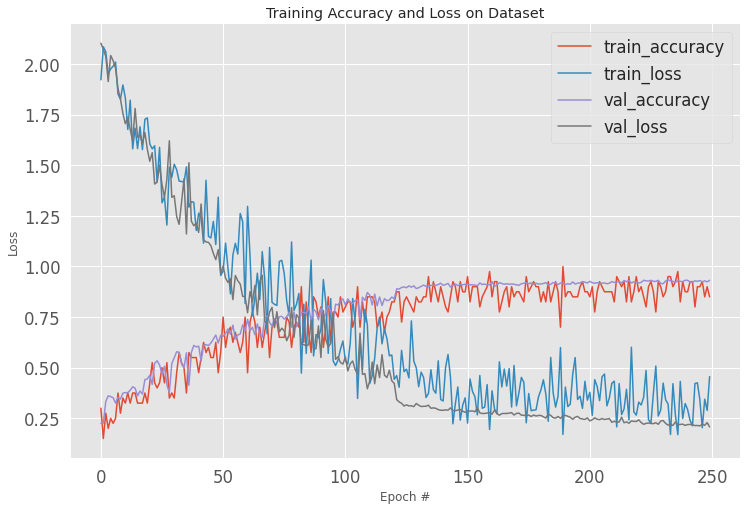

In [ ]:
plt.figure(figsize=(12, 8))
for key, values in history.items():
    plt.plot(values, label=key)
plt.title("Training Accuracy and Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
def load_ckpt(ckpt_path):
    print("[INFO] Loading checkpoint")
    model_state = torch.load(ckpt_path)
    model.load_state_dict(model_state)

In [ ]:
load_ckpt(CHECKPOINT_PATH)

[INFO] Loading checkpoint


In [ ]:
accuracy, loss = validate(model, val_dl, val_dataset, criterion)
clear_output()
print(f"Validation Accuracy = {accuracy}\nValidation Loss = {loss}")

Validation Accuracy = 0.931758530183727
Validation Loss = 0.20647570242484412


# Show inference results

In [ ]:
val_sequences = []
val_labels = []
for sequence, label in val_dataset:
    val_sequences.append(sequence.unsqueeze(0))
    val_labels.append(label)

val_sequences = torch.cat(val_sequences, axis=0).to(device)
val_labels = torch.stack(val_labels).to(device)
print(val_sequences.shape)
print(val_labels.shape)

torch.Size([3810, 128, 10])
torch.Size([3810])


In [ ]:
val_labels[:5]

tensor([2, 1, 1, 1, 6])

In [ ]:
model.eval()

with torch.no_grad():
    y_proba = model(val_sequences)
    y_pred = torch.argmax(y_proba, axis=-1)

    total_correct = (y_pred == val_labels).sum().item()
print(total_correct)

3413


In [ ]:
accuracy = total_correct / len(val_labels)
print(accuracy)

0.8958005249343832


In [ ]:
from sklearn.metrics import classification_report

print(
    classification_report(val_labels.cpu().numpy(), 
                          y_pred.cpu().numpy(), 
                          target_names=encoder.classes_
    )
)

                        precision    recall  f1-score   support

                carpet       0.85      0.89      0.87       189
              concrete       0.91      0.89      0.90       779
         fine_concrete       0.85      0.83      0.84       363
            hard_tiles       0.68      0.81      0.74        21
hard_tiles_large_space       0.96      0.91      0.93       308
              soft_pvc       0.90      0.92      0.91       732
            soft_tiles       0.90      0.96      0.93       297
                 tiled       0.91      0.88      0.89       514
                  wood       0.88      0.89      0.88       607

              accuracy                           0.90      3810
             macro avg       0.87      0.89      0.88      3810
          weighted avg       0.90      0.90      0.90      3810



In [ ]:
# make a single prediction
random_idx = np.random.randint(len(val_labels))

rand_sequence = val_sequences[random_idx].unsqueeze(0)
y_true = val_labels[random_idx]

y_proba = model(rand_sequence)
y_pred = torch.argmax(y_proba, axis=-1)

pred_class, true_class = encoder.inverse_transform([y_pred.item(), y_true.item()])

print(f"Predicted: {pred_class}; Actual: {true_class}")

Predicted: soft_pvc; Actual: soft_pvc


# Try Conv1D model

In [ ]:
for x, y in train_dl:
    print(x.shape)
    break

torch.Size([64, 128, 10])


In [ ]:
m = nn.Conv1d(128, 256, 3, stride=1)
output = m(x)
print(output.shape)

m = nn.Conv1d(256, 256, 3, stride=1)
output = m(output)
print(output.shape)

m = nn.Conv1d(256, 256, 3, stride=1)
output = m(output)
print(output.shape)

torch.Size([64, 256, 8])
torch.Size([64, 256, 6])
torch.Size([64, 256, 4])


In [ ]:
output.mean(-1).shape

torch.Size([1, 256])

In [ ]:
class SequenceConvModel(nn.Module):
    def __init__(self, sequence_len, n_classes=N_CLASSES, n_hidden=256, n_layers=3, verbose=0):
        super().__init__()

        self.n_layers = n_layers
        self.verbose = verbose
        self.conv1d_1 = nn.Conv1d(
            in_channels=sequence_len,
            out_channels=n_hidden,
            kernel_size=3,
        )
        self.bn = nn.BatchNorm1d(n_hidden)
        self.relu = nn.ReLU()

        self.conv1d_2 = nn.Conv1d(
            in_channels=n_hidden,
            out_channels=n_hidden,
            kernel_size=3,
        )

        self.fc = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        for i in range(self.n_layers):
            if i == 0:
                x = self.conv1d_1(x)
            else:
                x = self.conv1d_2(x)
            ## optionally print shapes to see the changes
            # print(x.shape)
            x = self.bn(x)
            # print(x.shape)
            x = self.relu(x)
            # print(x.shape)

        # global average pooling
        x = x.mean(axis=-1)
        # print(x.shape)

        x = self.fc(x)
        # print(x.shape)
        return x

In [ ]:
model = SequenceConvModel(
    sequence_len=SEQUENCE_LENGTH,
    n_classes=N_CLASSES,
    n_hidden=256,
    n_layers=3
)
model.to(device)

SequenceConvModel(
  (conv1d_1): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv1d_2): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [ ]:
model(x.to(device)).shape

torch.Size([64, 9])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

In [ ]:
from collections import defaultdict

# to store our training accuracy and losses
history = defaultdict(list)
best_val_loss = np.inf

for epoch in range(EPOCHS):
    print(f"Epoch ({epoch}/{EPOCHS}):", end="")
    start_t = time.perf_counter()

    train_accuracy, train_loss = fit(
        model,
        train_dl,
        train_dataset,
        optimizer,
        criterion
    )

    val_accuracy, val_loss = validate(
        model,
        val_dl,
        val_dataset,
        criterion
    )

    end_t = time.perf_counter()
    print(f" {end_t - start_t:.2f} s")

    ## optionally can save checkpoint automatically
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_ckpt(model.state_dict(), "conv1d_model_ckpt.pth.tar")
    
    scheduler.step(val_loss)

    history['train_accuracy'].append(train_accuracy)
    history['train_loss'].append(train_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_loss'].append(val_loss)

    print(f"accuracy = {train_accuracy}  loss = {train_loss}  "
    f"val_accuracy = {val_accuracy}  val_loss = {val_loss}\n")

Epoch (0/250):

 0.53 s
[INFO] Saving checkpoint
accuracy = 0.35  loss = 1.8685134649276733  val_accuracy = 0.3858267716535433  val_loss = 2.054148813088735

Epoch (1/250):

 0.52 s
[INFO] Saving checkpoint
accuracy = 0.35  loss = 1.6262222528457642  val_accuracy = 0.3884514435695538  val_loss = 2.001406192779541

Epoch (2/250):

 0.50 s
[INFO] Saving checkpoint
accuracy = 0.45  loss = 1.5352104902267456  val_accuracy = 0.3858267716535433  val_loss = 1.961215188105901

Epoch (3/250):

 0.50 s
[INFO] Saving checkpoint
accuracy = 0.525  loss = 1.3242249488830566  val_accuracy = 0.3805774278215223  val_loss = 1.9533019463221233

Epoch (4/250):

 0.48 s
[INFO] Saving checkpoint
accuracy = 0.525  loss = 1.4042149782180786  val_accuracy = 0.3661417322834646  val_loss = 1.9345272779464722

Epoch (5/250):

 0.50 s
[INFO] Saving checkpoint
accuracy = 0.675  loss = 1.1048606634140015  val_accuracy = 0.36876640419947504  val_loss = 1.9297284682591755

Epoch (6/250):

 0.49 s
[INFO] Saving checkpoint
accuracy = 0.6  loss = 1.2094985246658325  val_accuracy = 0.38188976377952755  val_loss = 1.9168894588947296

Epoch (7/250):

 0.49 s
accuracy = 0.675  loss = 1.1109367609024048  val_accuracy = 0.39763779527559057  val_loss = 1.9234680831432343

Epoch (8/250):

 0.49 s
[INFO] Saving checkpoint
accuracy = 0.725  loss = 1.0605576038360596  val_accuracy = 0.39501312335958005  val_loss = 1.9126664499441783

Epoch (9/250):

 0.47 s
accuracy = 0.675  loss = 1.0606906414031982  val_accuracy = 0.3910761154855643  val_loss = 1.9150671859582264

Epoch (10/250):

 0.50 s
accuracy = 0.825  loss = 0.8488283157348633  val_accuracy = 0.4146981627296588  val_loss = 1.913215845823288

Epoch (11/250):

 0.49 s
[INFO] Saving checkpoint
accuracy = 0.6  loss = 1.0019185543060303  val_accuracy = 0.41338582677165353  val_loss = 1.8864747285842896

Epoch (12/250):

 0.47 s
accuracy = 0.75  loss = 0.8465863466262817  val_accuracy = 0.4225721784776903  val_loss = 1.8935059309005737

Epoch (13/250):

 0.49 s
[INFO] Saving checkpoint
accuracy = 0.675  loss = 0.9885022044181824  val_accuracy = 0.431758530183727  val_loss = 1.8720890084902446

Epoch (14/250):

 0.48 s
[INFO] Saving checkpoint
accuracy = 0.75  loss = 0.7502049207687378  val_accuracy = 0.4553805774278215  val_loss = 1.857382744550705

Epoch (15/250):

 0.48 s
[INFO] Saving checkpoint
accuracy = 0.875  loss = 0.7081617116928101  val_accuracy = 0.484251968503937  val_loss = 1.844153771797816

Epoch (16/250):

 0.48 s
[INFO] Saving checkpoint
accuracy = 0.725  loss = 0.7499655485153198  val_accuracy = 0.5459317585301837  val_loss = 1.8371375898520153

Epoch (17/250):

 0.47 s
[INFO] Saving checkpoint
accuracy = 0.8  loss = 0.7391335964202881  val_accuracy = 0.5511811023622047  val_loss = 1.833258718252182

Epoch (18/250):

 0.46 s
[INFO] Saving checkpoint
accuracy = 0.775  loss = 0.6490997672080994  val_accuracy = 0.5695538057742782  val_loss = 1.8308399418989818

Epoch (19/250):

 0.48 s
[INFO] Saving checkpoint
accuracy = 0.825  loss = 0.7055893540382385  val_accuracy = 0.5341207349081365  val_loss = 1.81932932138443

Epoch (20/250):

 0.47 s
[INFO] Saving checkpoint
accuracy = 0.85  loss = 0.5792377591133118  val_accuracy = 0.5275590551181102  val_loss = 1.7799886961778004

Epoch (21/250):

 0.49 s
accuracy = 0.825  loss = 0.6288360953330994  val_accuracy = 0.5616797900262467  val_loss = 1.8226336240768433

Epoch (22/250):

 0.49 s
accuracy = 0.8  loss = 0.6134260892868042  val_accuracy = 0.5393700787401575  val_loss = 1.786725252866745

Epoch (23/250):

 0.47 s
[INFO] Saving checkpoint
accuracy = 0.85  loss = 0.6217590570449829  val_accuracy = 0.5590551181102362  val_loss = 1.763011356194814

Epoch (24/250):

 0.49 s
accuracy = 0.875  loss = 0.4837877154350281  val_accuracy = 0.5065616797900262  val_loss = 1.7806577881177266

Epoch (25/250):

 0.47 s
accuracy = 0.85  loss = 0.4012376666069031  val_accuracy = 0.5590551181102362  val_loss = 1.776725172996521

Epoch (26/250):

 0.47 s
[INFO] Saving checkpoint
accuracy = 0.825  loss = 0.43615564703941345  val_accuracy = 0.531496062992126  val_loss = 1.7616690695285797

Epoch (27/250):

 0.46 s
accuracy = 0.95  loss = 0.3669779598712921  val_accuracy = 0.5485564304461942  val_loss = 1.7669397095839183

Epoch (28/250):

 0.48 s
[INFO] Saving checkpoint
accuracy = 0.775  loss = 0.5961989164352417  val_accuracy = 0.5997375328083989  val_loss = 1.7510198652744293

Epoch (29/250):

 0.47 s
accuracy = 0.975  loss = 0.24940255284309387  val_accuracy = 0.536745406824147  val_loss = 1.763136972983678

Epoch (30/250):

 0.48 s
[INFO] Saving checkpoint
accuracy = 0.875  loss = 0.3848554491996765  val_accuracy = 0.5905511811023622  val_loss = 1.7311590611934662

Epoch (31/250):

 0.48 s
accuracy = 0.925  loss = 0.39383143186569214  val_accuracy = 0.531496062992126  val_loss = 1.770919144153595

Epoch (32/250):

 0.48 s
accuracy = 0.925  loss = 0.3800293803215027  val_accuracy = 0.5813648293963255  val_loss = 1.7499607801437378

Epoch (33/250):

 0.49 s
accuracy = 0.875  loss = 0.3700985908508301  val_accuracy = 0.5538057742782152  val_loss = 1.7810248136520386

Epoch (34/250):

 0.48 s
[INFO] Saving checkpoint
accuracy = 0.9  loss = 0.3092319369316101  val_accuracy = 0.5813648293963255  val_loss = 1.7272006173928578

Epoch (35/250):

 0.47 s
accuracy = 0.925  loss = 0.2758024334907532  val_accuracy = 0.562992125984252  val_loss = 1.7352551917235057

Epoch (36/250):

 0.49 s
accuracy = 0.975  loss = 0.20784911513328552  val_accuracy = 0.5131233595800525  val_loss = 1.7501669824123383

Epoch (37/250):

 0.47 s
accuracy = 1.0  loss = 0.15792451798915863  val_accuracy = 0.5511811023622047  val_loss = 1.7701544264952342

Epoch (38/250):

 0.48 s
accuracy = 0.95  loss = 0.20794722437858582  val_accuracy = 0.5091863517060368  val_loss = 1.7496849596500397

Epoch (39/250):

 0.50 s
accuracy = 0.975  loss = 0.16244849562644958  val_accuracy = 0.44750656167979  val_loss = 1.765333314736684

Epoch (40/250):

 0.48 s
accuracy = 0.95  loss = 0.2751108705997467  val_accuracy = 0.452755905511811  val_loss = 1.7807143727938335

Epoch (41/250):

 0.46 s
accuracy = 1.0  loss = 0.0993381217122078  val_accuracy = 0.48293963254593175  val_loss = 1.7541999320189159

Epoch (42/250):

 0.49 s
accuracy = 1.0  loss = 0.12786389887332916  val_accuracy = 0.5275590551181102  val_loss = 1.728048950433731

Epoch (43/250):

 0.47 s
accuracy = 0.925  loss = 0.27104517817497253  val_accuracy = 0.49343832020997375  val_loss = 1.7390487293402355

Epoch (44/250):

 0.49 s
accuracy = 0.95  loss = 0.16762688755989075  val_accuracy = 0.5183727034120735  val_loss = 1.7296023468176525

Epoch (45/250):

 0.48 s
accuracy = 0.975  loss = 0.13781340420246124  val_accuracy = 0.5078740157480315  val_loss = 1.7391759256521861

Epoch (46/250):

 0.48 s
accuracy = 1.0  loss = 0.15389224886894226  val_accuracy = 0.49606299212598426  val_loss = 1.7405367692311604

Epoch (47/250):

 0.49 s
accuracy = 0.975  loss = 0.16332128643989563  val_accuracy = 0.505249343832021  val_loss = 1.7471555570761363

Epoch (48/250):

 0.48 s
accuracy = 0.925  loss = 0.26060840487480164  val_accuracy = 0.48031496062992124  val_loss = 1.7563926080862682

Epoch (49/250):

 0.49 s
accuracy = 0.975  loss = 0.14464125037193298  val_accuracy = 0.5183727034120735  val_loss = 1.7477181951204936

Epoch (50/250):

 0.49 s
accuracy = 0.975  loss = 0.14827799797058105  val_accuracy = 0.5013123359580053  val_loss = 1.7449571291605632

Epoch (51/250):

 0.49 s
accuracy = 0.95  loss = 0.21988539397716522  val_accuracy = 0.5065616797900262  val_loss = 1.7412219643592834

Epoch (52/250):

 0.51 s
accuracy = 1.0  loss = 0.09648121893405914  val_accuracy = 0.5039370078740157  val_loss = 1.7411787907282512

Epoch (53/250):

 0.48 s
accuracy = 0.975  loss = 0.13334618508815765  val_accuracy = 0.484251968503937  val_loss = 1.7545588215192158

Epoch (54/250):

 0.49 s
accuracy = 0.95  loss = 0.22520804405212402  val_accuracy = 0.5144356955380578  val_loss = 1.755476862192154

Epoch (55/250):

 0.48 s
accuracy = 0.925  loss = 0.26798954606056213  val_accuracy = 0.49606299212598426  val_loss = 1.7534580131371815

Epoch (56/250):

 0.50 s
accuracy = 0.975  loss = 0.15395230054855347  val_accuracy = 0.48556430446194226  val_loss = 1.7550071080525715

Epoch (57/250):

 0.48 s
accuracy = 0.95  loss = 0.1932348906993866  val_accuracy = 0.5078740157480315  val_loss = 1.7425493995348613

Epoch (58/250):

 0.49 s
accuracy = 1.0  loss = 0.16728153824806213  val_accuracy = 0.5039370078740157  val_loss = 1.7452121078968048

Epoch (59/250):

 0.50 s
accuracy = 1.0  loss = 0.09151821583509445  val_accuracy = 0.5026246719160105  val_loss = 1.7390350997447968

Epoch (60/250):

 0.48 s
accuracy = 0.975  loss = 0.1432696282863617  val_accuracy = 0.4658792650918635  val_loss = 1.7554903030395508

Epoch (61/250):

 0.47 s
accuracy = 0.95  loss = 0.1856681853532791  val_accuracy = 0.49081364829396323  val_loss = 1.7497905492782593

Epoch (62/250):

 0.50 s
accuracy = 1.0  loss = 0.09676020592451096  val_accuracy = 0.520997375328084  val_loss = 1.7422524392604828

Epoch (63/250):

 0.48 s
accuracy = 0.975  loss = 0.1568901240825653  val_accuracy = 0.48293963254593175  val_loss = 1.7466689745585124

Epoch (64/250):

 0.50 s
accuracy = 1.0  loss = 0.11216101795434952  val_accuracy = 0.43832020997375326  val_loss = 1.7634242177009583

Epoch (65/250):

 0.47 s
accuracy = 1.0  loss = 0.09246411174535751  val_accuracy = 0.4776902887139108  val_loss = 1.7588822146256764

Epoch (66/250):

 0.49 s
accuracy = 1.0  loss = 0.08777032792568207  val_accuracy = 0.5131233595800525  val_loss = 1.7316586176554363

Epoch (67/250):

 0.48 s
accuracy = 1.0  loss = 0.11944892257452011  val_accuracy = 0.48293963254593175  val_loss = 1.7523187895615895

Epoch (68/250):

 0.51 s
accuracy = 0.975  loss = 0.1234138160943985  val_accuracy = 0.48556430446194226  val_loss = 1.7485921283562977

Epoch (69/250):

 0.47 s
accuracy = 0.975  loss = 0.1567177176475525  val_accuracy = 0.49868766404199477  val_loss = 1.7536970575650532

Epoch (70/250):

 0.48 s
accuracy = 0.975  loss = 0.1100163459777832  val_accuracy = 0.4816272965879265  val_loss = 1.7487615247567494

Epoch (71/250):

 0.48 s
accuracy = 0.975  loss = 0.23298995196819305  val_accuracy = 0.4881889763779528  val_loss = 1.7599288721879323

Epoch (72/250):

 0.50 s
accuracy = 1.0  loss = 0.13049784302711487  val_accuracy = 0.47244094488188976  val_loss = 1.759006788333257

Epoch (73/250):

 0.48 s
accuracy = 1.0  loss = 0.09499960392713547  val_accuracy = 0.47244094488188976  val_loss = 1.7529841661453247

Epoch (74/250):

 0.51 s
accuracy = 1.0  loss = 0.10033619403839111  val_accuracy = 0.505249343832021  val_loss = 1.7516415615876515

Epoch (75/250):

 0.49 s
accuracy = 1.0  loss = 0.12576159834861755  val_accuracy = 0.5144356955380578  val_loss = 1.7385768592357635

Epoch (76/250):

 0.49 s
accuracy = 0.925  loss = 0.22425469756126404  val_accuracy = 0.5131233595800525  val_loss = 1.7399088044961293

Epoch (77/250):

 0.50 s
accuracy = 1.0  loss = 0.0978165715932846  val_accuracy = 0.5026246719160105  val_loss = 1.7409929633140564

Epoch (78/250):

 0.48 s
accuracy = 0.975  loss = 0.23545654118061066  val_accuracy = 0.49343832020997375  val_loss = 1.7428701917330425

Epoch (79/250):

 0.49 s
accuracy = 1.0  loss = 0.08027137815952301  val_accuracy = 0.49606299212598426  val_loss = 1.753978321949641

Epoch (80/250):

 0.49 s
accuracy = 0.975  loss = 0.13774287700653076  val_accuracy = 0.49868766404199477  val_loss = 1.7407239973545074

Epoch (81/250):

 0.47 s
accuracy = 0.925  loss = 0.25155436992645264  val_accuracy = 0.5091863517060368  val_loss = 1.7457719147205353

Epoch (82/250):

 0.47 s
accuracy = 0.925  loss = 0.297346293926239  val_accuracy = 0.48556430446194226  val_loss = 1.7511920134226482

Epoch (83/250):

 0.49 s
accuracy = 0.95  loss = 0.1879355013370514  val_accuracy = 0.494750656167979  val_loss = 1.7473264932632446

Epoch (84/250):

 0.48 s
[INFO] Saving checkpoint
accuracy = 0.95  loss = 0.2594931423664093  val_accuracy = 0.531496062992126  val_loss = 1.7232764661312103

Epoch (85/250):

 0.50 s
accuracy = 0.95  loss = 0.15049055218696594  val_accuracy = 0.4973753280839895  val_loss = 1.7495562434196472

Epoch (86/250):

 0.48 s
accuracy = 0.975  loss = 0.12565460801124573  val_accuracy = 0.5091863517060368  val_loss = 1.747317334016164

Epoch (87/250):

 0.48 s
accuracy = 0.975  loss = 0.27421310544013977  val_accuracy = 0.45144356955380577  val_loss = 1.7648998200893402

Epoch (88/250):

 0.47 s
accuracy = 0.95  loss = 0.1782805323600769  val_accuracy = 0.510498687664042  val_loss = 1.755903422832489

Epoch (89/250):

 0.48 s
accuracy = 0.95  loss = 0.13381657004356384  val_accuracy = 0.47244094488188976  val_loss = 1.7615635991096497

Epoch (90/250):

 0.48 s
accuracy = 1.0  loss = 0.12197791039943695  val_accuracy = 0.4763779527559055  val_loss = 1.7529486616452534

Epoch (91/250):

 0.48 s
accuracy = 0.975  loss = 0.14797943830490112  val_accuracy = 0.49081364829396323  val_loss = 1.74366690715154

Epoch (92/250):

 0.47 s
accuracy = 0.95  loss = 0.15928509831428528  val_accuracy = 0.473753280839895  val_loss = 1.7547110418478649

Epoch (93/250):

 0.49 s
accuracy = 1.0  loss = 0.10936363786458969  val_accuracy = 0.47506561679790027  val_loss = 1.7513050536314647

Epoch (94/250):

 0.48 s
accuracy = 1.0  loss = 0.1021292582154274  val_accuracy = 0.47112860892388453  val_loss = 1.761357804139455

Epoch (95/250):

 0.50 s
accuracy = 0.975  loss = 0.18238891661167145  val_accuracy = 0.49606299212598426  val_loss = 1.7513009508450825

Epoch (96/250):

 0.46 s
accuracy = 0.975  loss = 0.13156870007514954  val_accuracy = 0.5  val_loss = 1.7504522502422333

Epoch (97/250):

 0.50 s
accuracy = 1.0  loss = 0.11739238351583481  val_accuracy = 0.515748031496063  val_loss = 1.7319799462954204

Epoch (98/250):

 0.47 s
accuracy = 0.95  loss = 0.16628265380859375  val_accuracy = 0.4921259842519685  val_loss = 1.7468758722146351

Epoch (99/250):

 0.48 s
accuracy = 0.95  loss = 0.22692258656024933  val_accuracy = 0.48556430446194226  val_loss = 1.7543146808942158

Epoch (100/250):

 0.47 s
accuracy = 1.0  loss = 0.12309849262237549  val_accuracy = 0.5131233595800525  val_loss = 1.7351259291172028

Epoch (101/250):

 0.48 s
accuracy = 0.975  loss = 0.2334560602903366  val_accuracy = 0.489501312335958  val_loss = 1.7362558543682098

Epoch (102/250):

 0.48 s
accuracy = 0.975  loss = 0.15069767832756042  val_accuracy = 0.45144356955380577  val_loss = 1.7660651206970215

Epoch (103/250):

 0.48 s
accuracy = 0.95  loss = 0.16583094000816345  val_accuracy = 0.5275590551181102  val_loss = 1.7304595112800598

Epoch (104/250):

 0.49 s
accuracy = 0.95  loss = 0.16722582280635834  val_accuracy = 0.5249343832020997  val_loss = 1.7284038563569386

Epoch (105/250):

 0.48 s
accuracy = 1.0  loss = 0.13617001473903656  val_accuracy = 0.45931758530183725  val_loss = 1.760963906844457

Epoch (106/250):

 0.49 s
accuracy = 0.975  loss = 0.13299618661403656  val_accuracy = 0.48293963254593175  val_loss = 1.7519083420435588

Epoch (107/250):

 0.49 s
accuracy = 1.0  loss = 0.11926152557134628  val_accuracy = 0.5170603674540682  val_loss = 1.7317340075969696

Epoch (108/250):

 0.50 s
accuracy = 0.95  loss = 0.1665402054786682  val_accuracy = 0.4881889763779528  val_loss = 1.7503060003121693

Epoch (109/250):

 0.48 s
accuracy = 0.975  loss = 0.14518311619758606  val_accuracy = 0.484251968503937  val_loss = 1.7591625054677327

Epoch (110/250):

 0.50 s
accuracy = 1.0  loss = 0.07849058508872986  val_accuracy = 0.49081364829396323  val_loss = 1.7532642583052318

Epoch (111/250):

 0.48 s
accuracy = 0.975  loss = 0.1346236914396286  val_accuracy = 0.489501312335958  val_loss = 1.7488568524519603

Epoch (112/250):

 0.51 s
accuracy = 0.975  loss = 0.14478912949562073  val_accuracy = 0.5170603674540682  val_loss = 1.7345429162184398

Epoch (113/250):

 0.50 s
accuracy = 0.95  loss = 0.23809294402599335  val_accuracy = 0.48556430446194226  val_loss = 1.7544936835765839

Epoch (114/250):

 0.48 s
accuracy = 0.975  loss = 0.1291116178035736  val_accuracy = 0.468503937007874  val_loss = 1.7542769014835358

Epoch (115/250):

 0.48 s
accuracy = 0.95  loss = 0.257062166929245  val_accuracy = 0.4868766404199475  val_loss = 1.757995883623759

Epoch (116/250):

 0.52 s
accuracy = 1.0  loss = 0.11942168325185776  val_accuracy = 0.4973753280839895  val_loss = 1.7475579281648

Epoch (117/250):

 0.48 s
accuracy = 0.95  loss = 0.15724721550941467  val_accuracy = 0.48556430446194226  val_loss = 1.7598258753617604

Epoch (118/250):

 0.50 s
accuracy = 1.0  loss = 0.158389613032341  val_accuracy = 0.5511811023622047  val_loss = 1.726200004418691

Epoch (119/250):

 0.47 s
accuracy = 0.95  loss = 0.2354450225830078  val_accuracy = 0.4973753280839895  val_loss = 1.7533836265405018

Epoch (120/250):

 0.50 s
accuracy = 0.975  loss = 0.18008868396282196  val_accuracy = 0.5026246719160105  val_loss = 1.741004337867101

Epoch (121/250):

 0.47 s
accuracy = 0.975  loss = 0.1555335521697998  val_accuracy = 0.452755905511811  val_loss = 1.7596156597137451

Epoch (122/250):

 0.53 s
accuracy = 1.0  loss = 0.11696984618902206  val_accuracy = 0.5118110236220472  val_loss = 1.7429500023523967

Epoch (123/250):

 0.47 s
accuracy = 0.975  loss = 0.14102932810783386  val_accuracy = 0.5026246719160105  val_loss = 1.7556811074415843

Epoch (124/250):

 0.49 s
accuracy = 0.95  loss = 0.26264578104019165  val_accuracy = 0.4921259842519685  val_loss = 1.7452983856201172

Epoch (125/250):

 0.49 s
accuracy = 1.0  loss = 0.08260014653205872  val_accuracy = 0.47112860892388453  val_loss = 1.7546468873818715

Epoch (126/250):

 0.49 s
accuracy = 0.95  loss = 0.19279488921165466  val_accuracy = 0.479002624671916  val_loss = 1.7529233694076538

Epoch (127/250):

 0.50 s
accuracy = 1.0  loss = 0.11297128349542618  val_accuracy = 0.5091863517060368  val_loss = 1.7405482331911724

Epoch (128/250):

 0.50 s
accuracy = 1.0  loss = 0.14695081114768982  val_accuracy = 0.47244094488188976  val_loss = 1.7575820287068684

Epoch (129/250):

 0.48 s
accuracy = 0.925  loss = 0.19101180136203766  val_accuracy = 0.489501312335958  val_loss = 1.7409314413865407

Epoch (130/250):

 0.49 s
accuracy = 0.95  loss = 0.1923704445362091  val_accuracy = 0.4658792650918635  val_loss = 1.760814239581426

Epoch (131/250):

 0.49 s
accuracy = 0.975  loss = 0.16608819365501404  val_accuracy = 0.4921259842519685  val_loss = 1.7496110995610554

Epoch (132/250):

 0.48 s
accuracy = 0.975  loss = 0.12209290266036987  val_accuracy = 0.49343832020997375  val_loss = 1.7463462551434834

Epoch (133/250):

 0.48 s
accuracy = 0.95  loss = 0.21521449089050293  val_accuracy = 0.48556430446194226  val_loss = 1.7445801397164662

Epoch (134/250):

 0.49 s
accuracy = 0.95  loss = 0.19626490771770477  val_accuracy = 0.5196850393700787  val_loss = 1.7347582479317982

Epoch (135/250):

 0.51 s
accuracy = 0.9  loss = 0.3241105377674103  val_accuracy = 0.5249343832020997  val_loss = 1.7341889242331188

Epoch (136/250):

 0.48 s
accuracy = 1.0  loss = 0.10975246131420135  val_accuracy = 0.48556430446194226  val_loss = 1.7531767984231312

Epoch (137/250):

 0.49 s
accuracy = 0.95  loss = 0.25925371050834656  val_accuracy = 0.4973753280839895  val_loss = 1.7459933658440907

Epoch (138/250):

 0.51 s
accuracy = 1.0  loss = 0.1331016719341278  val_accuracy = 0.49606299212598426  val_loss = 1.7504463990529378

Epoch (139/250):

 0.50 s
accuracy = 0.925  loss = 0.3275614082813263  val_accuracy = 0.4881889763779528  val_loss = 1.7552688717842102

Epoch (140/250):

 0.49 s
accuracy = 0.95  loss = 0.23298418521881104  val_accuracy = 0.515748031496063  val_loss = 1.7308914462725322

Epoch (141/250):

 0.47 s
accuracy = 0.95  loss = 0.2578638195991516  val_accuracy = 0.5091863517060368  val_loss = 1.7375873625278473

Epoch (142/250):

 0.49 s
accuracy = 0.95  loss = 0.22164495289325714  val_accuracy = 0.505249343832021  val_loss = 1.7421992818514507

Epoch (143/250):

 0.49 s
accuracy = 1.0  loss = 0.10712536424398422  val_accuracy = 0.49868766404199477  val_loss = 1.7406726777553558

Epoch (144/250):

 0.48 s
accuracy = 0.975  loss = 0.13497933745384216  val_accuracy = 0.4816272965879265  val_loss = 1.7613744139671326

Epoch (145/250):

 0.49 s
accuracy = 1.0  loss = 0.14252783358097076  val_accuracy = 0.5091863517060368  val_loss = 1.7406827608744304

Epoch (146/250):

 0.48 s
accuracy = 0.975  loss = 0.18643246591091156  val_accuracy = 0.479002624671916  val_loss = 1.7615633308887482

Epoch (147/250):

 0.48 s
accuracy = 1.0  loss = 0.09914623200893402  val_accuracy = 0.520997375328084  val_loss = 1.7397878567377727

Epoch (148/250):

 0.49 s
accuracy = 0.975  loss = 0.11028139293193817  val_accuracy = 0.48556430446194226  val_loss = 1.7573558986186981

Epoch (149/250):

 0.48 s
accuracy = 0.975  loss = 0.20068761706352234  val_accuracy = 0.45144356955380577  val_loss = 1.7668819626172383

Epoch (150/250):

 0.48 s
accuracy = 0.975  loss = 0.13077004253864288  val_accuracy = 0.5065616797900262  val_loss = 1.7417079508304596

Epoch (151/250):

 0.49 s
accuracy = 0.975  loss = 0.19086244702339172  val_accuracy = 0.5013123359580053  val_loss = 1.759696255127589

Epoch (152/250):

 0.50 s
accuracy = 1.0  loss = 0.1276482343673706  val_accuracy = 0.5249343832020997  val_loss = 1.7324837644894917

Epoch (153/250):

 0.50 s
accuracy = 0.975  loss = 0.10899476706981659  val_accuracy = 0.4868766404199475  val_loss = 1.748235414425532

Epoch (154/250):

 0.50 s
accuracy = 1.0  loss = 0.11764900386333466  val_accuracy = 0.5013123359580053  val_loss = 1.7402105927467346

Epoch (155/250):

 0.50 s
accuracy = 0.95  loss = 0.1776183694601059  val_accuracy = 0.484251968503937  val_loss = 1.7630536754926045

Epoch (156/250):

 0.52 s
accuracy = 0.975  loss = 0.13756772875785828  val_accuracy = 0.494750656167979  val_loss = 1.745588779449463

Epoch (157/250):

 0.49 s
accuracy = 0.95  loss = 0.23086205124855042  val_accuracy = 0.458005249343832  val_loss = 1.7617704570293427

Epoch (158/250):

 0.51 s
accuracy = 1.0  loss = 0.15548044443130493  val_accuracy = 0.4868766404199475  val_loss = 1.753217875957489

Epoch (159/250):

 0.50 s
accuracy = 1.0  loss = 0.1861506998538971  val_accuracy = 0.44750656167979  val_loss = 1.7811371386051178

Epoch (160/250):

 0.50 s
accuracy = 0.975  loss = 0.19192185997962952  val_accuracy = 0.5118110236220472  val_loss = 1.7307209372520447

Epoch (161/250):

 0.49 s
accuracy = 1.0  loss = 0.1318199187517166  val_accuracy = 0.48293963254593175  val_loss = 1.7488580445448558

Epoch (162/250):

 0.50 s
accuracy = 0.925  loss = 0.3522058129310608  val_accuracy = 0.4973753280839895  val_loss = 1.7431121269861858

Epoch (163/250):

 0.48 s
accuracy = 0.95  loss = 0.1890730857849121  val_accuracy = 0.5118110236220472  val_loss = 1.7358392576376598

Epoch (164/250):

 0.50 s
accuracy = 0.975  loss = 0.1925833523273468  val_accuracy = 0.48556430446194226  val_loss = 1.7510331273078918

Epoch (165/250):

 0.50 s
accuracy = 0.975  loss = 0.11134060472249985  val_accuracy = 0.479002624671916  val_loss = 1.7485005656878154

Epoch (166/250):

 0.50 s
accuracy = 0.975  loss = 0.1715877652168274  val_accuracy = 0.47506561679790027  val_loss = 1.755622237920761

Epoch (167/250):

 0.51 s
accuracy = 1.0  loss = 0.07264292240142822  val_accuracy = 0.5026246719160105  val_loss = 1.7543045779069264

Epoch (168/250):

 0.51 s
accuracy = 0.9  loss = 0.28854432702064514  val_accuracy = 0.5118110236220472  val_loss = 1.7354549566904705

Epoch (169/250):

 0.49 s
accuracy = 0.975  loss = 0.16679039597511292  val_accuracy = 0.5039370078740157  val_loss = 1.7382795015970867

Epoch (170/250):

 0.50 s
accuracy = 0.975  loss = 0.15276114642620087  val_accuracy = 0.49606299212598426  val_loss = 1.7412704825401306

Epoch (171/250):

 0.50 s
accuracy = 0.975  loss = 0.15158505737781525  val_accuracy = 0.5275590551181102  val_loss = 1.7340295910835266

Epoch (172/250):

 0.50 s
accuracy = 1.0  loss = 0.08217035233974457  val_accuracy = 0.4763779527559055  val_loss = 1.747753878434499

Epoch (173/250):

 0.51 s
accuracy = 0.95  loss = 0.21193301677703857  val_accuracy = 0.49868766404199477  val_loss = 1.7413273056348164

Epoch (174/250):

 0.48 s
accuracy = 1.0  loss = 0.09765781462192535  val_accuracy = 0.46981627296587924  val_loss = 1.7626619637012482

Epoch (175/250):

 0.49 s
accuracy = 0.975  loss = 0.11091122776269913  val_accuracy = 0.48556430446194226  val_loss = 1.746774007876714

Epoch (176/250):

 0.49 s
accuracy = 0.975  loss = 0.12365684658288956  val_accuracy = 0.505249343832021  val_loss = 1.7406951189041138

Epoch (177/250):

 0.48 s
accuracy = 0.975  loss = 0.14366582036018372  val_accuracy = 0.49606299212598426  val_loss = 1.7587720553080242

Epoch (178/250):

 0.49 s
accuracy = 0.975  loss = 0.13184064626693726  val_accuracy = 0.49606299212598426  val_loss = 1.7367160717646282

Epoch (179/250):

 0.49 s
accuracy = 0.975  loss = 0.14037398993968964  val_accuracy = 0.5  val_loss = 1.7421863575776417

Epoch (180/250):

 0.52 s
accuracy = 1.0  loss = 0.10650130361318588  val_accuracy = 0.5065616797900262  val_loss = 1.7421279152234395

Epoch (181/250):

 0.49 s
accuracy = 0.975  loss = 0.18565428256988525  val_accuracy = 0.505249343832021  val_loss = 1.7367189129193623

Epoch (182/250):

 0.51 s
accuracy = 0.975  loss = 0.14421671628952026  val_accuracy = 0.49868766404199477  val_loss = 1.7488556106885274

Epoch (183/250):

 0.50 s
accuracy = 0.95  loss = 0.20560748875141144  val_accuracy = 0.4763779527559055  val_loss = 1.7507558564345043

Epoch (184/250):

 0.49 s
accuracy = 0.925  loss = 0.39013779163360596  val_accuracy = 0.489501312335958  val_loss = 1.761004904905955

Epoch (185/250):

 0.50 s
accuracy = 1.0  loss = 0.09382034093141556  val_accuracy = 0.5039370078740157  val_loss = 1.743059863646825

Epoch (186/250):

 0.48 s
accuracy = 0.925  loss = 0.22136585414409637  val_accuracy = 0.479002624671916  val_loss = 1.744021197160085

Epoch (187/250):

 0.51 s
accuracy = 0.975  loss = 0.15058700740337372  val_accuracy = 0.49081364829396323  val_loss = 1.7437110145886738

Epoch (188/250):

 0.48 s
accuracy = 0.95  loss = 0.21730537712574005  val_accuracy = 0.5118110236220472  val_loss = 1.7356779078642528

Epoch (189/250):

 0.51 s
accuracy = 1.0  loss = 0.15759675204753876  val_accuracy = 0.49606299212598426  val_loss = 1.7395541667938232

Epoch (190/250):

 0.48 s
accuracy = 0.95  loss = 0.2558017373085022  val_accuracy = 0.5118110236220472  val_loss = 1.7405634621779125

Epoch (191/250):

 0.50 s
accuracy = 0.925  loss = 0.23735825717449188  val_accuracy = 0.5  val_loss = 1.7448517779509227

Epoch (192/250):

 0.50 s
accuracy = 0.95  loss = 0.2680198848247528  val_accuracy = 0.5078740157480315  val_loss = 1.7481025159358978

Epoch (193/250):

 0.50 s
accuracy = 1.0  loss = 0.08654378354549408  val_accuracy = 0.48293963254593175  val_loss = 1.7513360182444255

Epoch (194/250):

 0.50 s
accuracy = 1.0  loss = 0.08725284039974213  val_accuracy = 0.5196850393700787  val_loss = 1.731882522503535

Epoch (195/250):

 0.51 s
accuracy = 1.0  loss = 0.12287936359643936  val_accuracy = 0.48556430446194226  val_loss = 1.7540360788504283

Epoch (196/250):

 0.49 s
accuracy = 0.95  loss = 0.1468755155801773  val_accuracy = 0.5078740157480315  val_loss = 1.743272344271342

Epoch (197/250):

 0.50 s
accuracy = 0.975  loss = 0.16630885004997253  val_accuracy = 0.5118110236220472  val_loss = 1.7433319687843323

Epoch (198/250):

 0.49 s
accuracy = 0.975  loss = 0.1696833223104477  val_accuracy = 0.47506561679790027  val_loss = 1.7613526086012523

Epoch (199/250):

 0.50 s
accuracy = 1.0  loss = 0.13076376914978027  val_accuracy = 0.5091863517060368  val_loss = 1.742127964893977

Epoch (200/250):

 0.49 s
accuracy = 0.975  loss = 0.2680068910121918  val_accuracy = 0.5118110236220472  val_loss = 1.7398091753323872

Epoch (201/250):

 0.53 s
accuracy = 1.0  loss = 0.09745585918426514  val_accuracy = 0.494750656167979  val_loss = 1.7588245670000713

Epoch (202/250):

 0.50 s
accuracy = 0.925  loss = 0.28846025466918945  val_accuracy = 0.5039370078740157  val_loss = 1.7501904269059498

Epoch (203/250):

 0.48 s
accuracy = 1.0  loss = 0.11792878806591034  val_accuracy = 0.5131233595800525  val_loss = 1.733537604411443

Epoch (204/250):

 0.49 s
accuracy = 0.975  loss = 0.13198992609977722  val_accuracy = 0.5065616797900262  val_loss = 1.7535083889961243

Epoch (205/250):

 0.50 s
accuracy = 1.0  loss = 0.1450474113225937  val_accuracy = 0.4816272965879265  val_loss = 1.7559774816036224

Epoch (206/250):

 0.48 s
accuracy = 0.975  loss = 0.16927902400493622  val_accuracy = 0.5223097112860893  val_loss = 1.7385343313217163

Epoch (207/250):

 0.48 s
accuracy = 0.925  loss = 0.24161048233509064  val_accuracy = 0.5039370078740157  val_loss = 1.740347534418106

Epoch (208/250):

 0.49 s
accuracy = 0.975  loss = 0.19981010258197784  val_accuracy = 0.5341207349081365  val_loss = 1.7311597963174183

Epoch (209/250):

 0.51 s
accuracy = 0.95  loss = 0.16540083289146423  val_accuracy = 0.4763779527559055  val_loss = 1.7529632945855458

Epoch (210/250):

 0.50 s
accuracy = 0.95  loss = 0.17384180426597595  val_accuracy = 0.5131233595800525  val_loss = 1.744557778040568

Epoch (211/250):

 0.51 s
accuracy = 0.975  loss = 0.16260077059268951  val_accuracy = 0.5065616797900262  val_loss = 1.734486718972524

Epoch (212/250):

 0.48 s
accuracy = 1.0  loss = 0.10507305711507797  val_accuracy = 0.505249343832021  val_loss = 1.7389972805976868

Epoch (213/250):

 0.49 s
accuracy = 0.975  loss = 0.18891021609306335  val_accuracy = 0.510498687664042  val_loss = 1.7307868500550587

Epoch (214/250):

 0.50 s
accuracy = 0.9  loss = 0.2450614720582962  val_accuracy = 0.4868766404199475  val_loss = 1.7568717102209728

Epoch (215/250):

 0.51 s
accuracy = 0.975  loss = 0.1748269498348236  val_accuracy = 0.48556430446194226  val_loss = 1.7538712918758392

Epoch (216/250):

 0.50 s
accuracy = 1.0  loss = 0.07017217576503754  val_accuracy = 0.463254593175853  val_loss = 1.7588369747002919

Epoch (217/250):

 0.51 s
accuracy = 0.975  loss = 0.15233390033245087  val_accuracy = 0.4776902887139108  val_loss = 1.7639127373695374

Epoch (218/250):

 0.48 s
accuracy = 1.0  loss = 0.10910648107528687  val_accuracy = 0.5  val_loss = 1.752461353937785

Epoch (219/250):

 0.52 s
accuracy = 0.975  loss = 0.142580047249794  val_accuracy = 0.5118110236220472  val_loss = 1.7334629396597545

Epoch (220/250):

 0.49 s
accuracy = 0.975  loss = 0.1913314312696457  val_accuracy = 0.5091863517060368  val_loss = 1.737089325984319

Epoch (221/250):

 0.49 s
accuracy = 0.925  loss = 0.22930753231048584  val_accuracy = 0.49343832020997375  val_loss = 1.7527163624763489

Epoch (222/250):

 0.52 s
accuracy = 0.95  loss = 0.15876075625419617  val_accuracy = 0.5039370078740157  val_loss = 1.7447248895963032

Epoch (223/250):

 0.50 s
accuracy = 0.95  loss = 0.15008072555065155  val_accuracy = 0.4816272965879265  val_loss = 1.7495283484458923

Epoch (224/250):

 0.49 s
accuracy = 1.0  loss = 0.09382244199514389  val_accuracy = 0.4868766404199475  val_loss = 1.7512667675813038

Epoch (225/250):

 0.52 s
accuracy = 1.0  loss = 0.09362838417291641  val_accuracy = 0.48556430446194226  val_loss = 1.7437046865622203

Epoch (226/250):

 0.48 s
accuracy = 0.95  loss = 0.27071312069892883  val_accuracy = 0.5301837270341208  val_loss = 1.7236205041408539

Epoch (227/250):

 0.50 s
accuracy = 0.975  loss = 0.1900499165058136  val_accuracy = 0.5065616797900262  val_loss = 1.7479226489861805

Epoch (228/250):

 0.50 s
accuracy = 1.0  loss = 0.07505897432565689  val_accuracy = 0.458005249343832  val_loss = 1.7564839720726013

Epoch (229/250):

 0.50 s
accuracy = 0.95  loss = 0.18300262093544006  val_accuracy = 0.5  val_loss = 1.7545569638411205

Epoch (230/250):

 0.50 s
accuracy = 0.95  loss = 0.15284962952136993  val_accuracy = 0.510498687664042  val_loss = 1.7439958254496257

Epoch (231/250):

 0.52 s
accuracy = 0.975  loss = 0.1604776233434677  val_accuracy = 0.5118110236220472  val_loss = 1.730751633644104

Epoch (232/250):

 0.49 s
accuracy = 0.975  loss = 0.13124476373195648  val_accuracy = 0.4921259842519685  val_loss = 1.751710683107376

Epoch (233/250):

 0.50 s
accuracy = 1.0  loss = 0.08374899625778198  val_accuracy = 0.4973753280839895  val_loss = 1.7483019530773163

Epoch (234/250):

 0.49 s
accuracy = 1.0  loss = 0.11486263573169708  val_accuracy = 0.4973753280839895  val_loss = 1.754645824432373

Epoch (235/250):

 0.53 s
accuracy = 0.95  loss = 0.17543968558311462  val_accuracy = 0.5131233595800525  val_loss = 1.7336386740207672

Epoch (236/250):

 0.50 s
accuracy = 0.975  loss = 0.1662219762802124  val_accuracy = 0.5118110236220472  val_loss = 1.7290875315666199

Epoch (237/250):

 0.49 s
accuracy = 0.95  loss = 0.19686995446681976  val_accuracy = 0.5091863517060368  val_loss = 1.7491757571697235

Epoch (238/250):

 0.51 s
accuracy = 1.0  loss = 0.11564303934574127  val_accuracy = 0.5013123359580053  val_loss = 1.7410051027933757

Epoch (239/250):

 0.51 s
accuracy = 1.0  loss = 0.0952276885509491  val_accuracy = 0.4868766404199475  val_loss = 1.7485297719637554

Epoch (240/250):

 0.51 s
accuracy = 0.925  loss = 0.2135039120912552  val_accuracy = 0.5078740157480315  val_loss = 1.750493049621582

Epoch (241/250):

 0.49 s
accuracy = 0.95  loss = 0.20077034831047058  val_accuracy = 0.5144356955380578  val_loss = 1.7448998192946117

Epoch (242/250):

 0.51 s
accuracy = 1.0  loss = 0.1541782021522522  val_accuracy = 0.5078740157480315  val_loss = 1.7474929690361023

Epoch (243/250):

 0.50 s
accuracy = 0.975  loss = 0.21617135405540466  val_accuracy = 0.4973753280839895  val_loss = 1.7439594666163127

Epoch (244/250):

 0.50 s
accuracy = 1.0  loss = 0.08783655613660812  val_accuracy = 0.5144356955380578  val_loss = 1.742480605840683

Epoch (245/250):

 0.51 s
accuracy = 0.975  loss = 0.15547038614749908  val_accuracy = 0.5078740157480315  val_loss = 1.7483913898468018

Epoch (246/250):

 0.51 s
accuracy = 1.0  loss = 0.12629434466362  val_accuracy = 0.4658792650918635  val_loss = 1.7553574244181316

Epoch (247/250):

 0.48 s
accuracy = 0.95  loss = 0.17380525171756744  val_accuracy = 0.4973753280839895  val_loss = 1.7452649772167206

Epoch (248/250):

 0.52 s
accuracy = 1.0  loss = 0.0609063096344471  val_accuracy = 0.484251968503937  val_loss = 1.75143497188886

Epoch (249/250):

 0.50 s
accuracy = 0.975  loss = 0.14894865453243256  val_accuracy = 0.5078740157480315  val_loss = 1.73232505718867

